In [0]:
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output
import itertools

class TorchSin(torch.nn.Module):
    """
    Sin activation function
    """
    def __init__(self):
        super(TorchSin, self).__init__()

    def forward(self, x):
        return torch.sin(x)

class ResidualBlock(nn.Module):
    # Most basic residual block
    # https://arxiv.org/pdf/1512.03385.pdf
    # ^ Equation #1

    def __init__(self, n_units, activation):
        super(ResidualBlock, self).__init__()

        self.activation = activation
        self.l1 = nn.Linear(n_units, n_units)
        self.l2 = nn.Linear(n_units, n_units)
      
    def forward(self, x):
        return self.activation(
            self.l2(self.activation(self.l1(x))) + x
        )

class Generator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(), output_tan=True):
        
        super(Generator, self).__init__()

        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            self.layers.append(ResidualBlock(n_hidden_units, activation))
            # self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            # self.layers.append(activation)
            
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if output_tan:
            self.layers.append(nn.Tanh())

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(), unbounded=False):
        
        super(Discriminator, self).__init__()
        
        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            # self.layers.append(ResidualBlock(n_hidden_units, activation))
            self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            self.layers.append(activation)
        
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if not unbounded:
            # unbounded for WGAN (no sigmoid)
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        # x = x.reshape(1,-1)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

def realtime_vis(g_loss, d_loss, t, analytic, preds, dx_dt, d2x_dt2, savefig=False, fname=None):
    fig, ax = plt.subplots(1,3,figsize=(20,6))
    steps = len(g_loss)
    epochs = np.arange(steps)

    ax[0].plot(epochs, g_loss, label='g_loss', color='orange')
    ax[0].plot(epochs, [d[0] for d in d_loss], label='d_loss', color='blue')
    ax[0].plot(epochs, [d[1] for d in d_loss], label='d_loss2', color='green')
    # ax[0].plot(epochs, [d[2] for d in d_loss], label='d_loss_real', color='blue')
    ax[0].legend()
    ax[0].set_title('Losses')

    ax[1].plot(t, preds, label='pred', color='orange')
    ax[1].plot(t, analytic, '--', label='true', color='blue')
    ax[1].legend()
    ax[1].set_title('Prediction')

    ax[2].plot(t, preds, label='x', color='orange')
    ax[2].plot(t, -d2x_dt2, '--', label="-x''", color='green')
    ax[2].legend()
    ax[2].set_title('Derivatives')

    if not savefig:
        plt.show()
    else:
        plt.savefig(fname)

def diff(x, t):
    dx_dt, = autograd.grad(x, t,
                           grad_outputs=x.data.new(x.shape).fill_(1),
                           create_graph=True)
    return dx_dt

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         torch.nn.init.normal(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm2d') != -1:
#         torch.nn.init.normal(m.weight.data, 1.0, 0.02)
#         torch.nn.init.constant(m.bias.data, 0.0)

def calc_gradient_penalty(disc, real_data, generated_data, gp_lambda, cuda=False):
  batch_size = real_data.size()[0]

  # Calculate interpolation
  alpha = torch.rand(batch_size, 1)
  alpha = alpha.expand_as(real_data)
  if cuda:
    alpha = alpha.cuda()
  interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
  interpolated = autograd.Variable(interpolated, requires_grad=True)
  if cuda:
    interpolated = interpolated.cuda()

  # Calculate probability of interpolated examples
  prob_interpolated = disc(interpolated)

  # Calculate gradients of probabilities with respect to examples
  gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                         grad_outputs=torch.ones(prob_interpolated.size()).cuda() if cuda else torch.ones(
                               prob_interpolated.size()),
                         create_graph=True, retain_graph=True)[0]

  # Gradients have shape (batch_size, num_channels, img_width, img_height),
  # so flatten to easily take norm per example in batch
  gradients = gradients.view(batch_size, -1)
  # self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

  # Derivatives of the gradient close to 0 can cause problems because of
  # the square root, so manually calculate norm and add epsilon
  gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

  # Return gradient penalty
  return gp_lambda * ((gradients_norm - 1) ** 2).mean()

def exponential_weight_average(prev_weights, curr_weights, beta=0.9):
    """ returns exponential moving average of prev_weights and curr_weights 
        (beta=0 => no averaging) """
    return beta*prev_weights + (1-beta)*curr_weights

In [0]:
gnet = Generator(n_hidden_units=30, n_hidden_layers=30)

In [0]:
t = torch.linspace(0,12,100).reshape(-1,1)
y = torch.sin(t)
opt = torch.optim.Adam(gnet.parameters())
mse = torch.nn.MSELoss()

for i in range(1000):
  opt.zero_grad()
  pred = gnet(t)
  loss = mse(pred, y)
  loss.backward()
  opt.step()

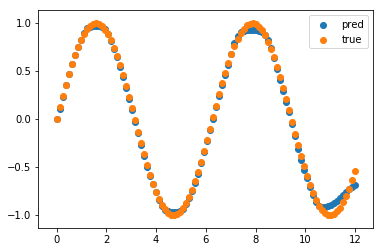

In [44]:
plt.scatter(t.detach().numpy(), gnet(t).detach().numpy(), label='pred')
plt.scatter(t.detach().numpy(), y.detach().numpy(), label='true')
plt.legend()

In [53]:
total_param = sum(p.numel() for p in gnet.parameters())
print(total_param)

55891


In [0]:
def train_GAN_SHO(
    # Architecture
    num_epochs,
    activation=nn.Tanh(),
    g_hidden_units=10,
    d_hidden_units=10,
    g_hidden_layers=2,
    d_hidden_layers=2,
    d_lr=0.001,
    g_lr=0.001,
    d_betas=(0.9, 0.999),
    g_betas=(0.9, 0.999),
    G_iters=1,
    D_iters=1,
    # Problem
    t_low=0,
    t_high=10,
    x0=0,
    dx_dt0=.5,
    n=100,
    m=1.,
    k=1.,
    real_label=1,
    fake_label=0,
    # Hacks
    perturb=True,
    real_data=False,
    semi_supervised=False,
    observe_every=1,
    wgan=True,
    gp_hyper=1.0,
    d2_hyper=1.0,
    outputTan=True,
    systemOfODE=True,
    conditionalGAN=True,
    lr_schedule=True,
    decay_start_epoch=5000,
    # Inspect
    savefig=False,
    fname=None,
    device=None,
    check_every=100,
    logging=False,
    realtime_plot=True,
    seed=42,
):

    """
    function to perform training of generator and discriminator for num_epochs
    equation: simple harmonic oscillator (SHO)
    gan hacks:
        - wasserstein + clipping / wasserstein GP
        - label smoothing
        - while loop iters
    """
    torch.manual_seed(seed) # reproducibility
    
    cuda = torch.cuda.is_available()
    
    if savefig and realtime_plot:
        raise Exception('savefig and realtime_plot both True. Assuming you dont want that.')

    if wgan:
        fake_label = -1

    # initialize nets
    G = Generator(in_dim=1, out_dim=1,
                  n_hidden_units=g_hidden_units,
                  n_hidden_layers=g_hidden_layers,
                  activation=activation, # twice diff'able activation
                  output_tan=outputTan) # true output range should be (-1,1) if True
    if cuda:
      G.cuda()

    d_in_dim = 2 if conditionalGAN else 1
    D = Discriminator(in_dim=d_in_dim, out_dim=1,
                      n_hidden_units=d_hidden_units,
                      n_hidden_layers=d_hidden_layers,
                      activation=activation,
                      unbounded=wgan) # true for WGAN

    # make D2 an exact (deep) copy of D
    D2 = deepcopy(D)

    if cuda:
      D.cuda()
      D2.cuda()

    # grid
    t_torch = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    if cuda:
      t_torch = t_torch.cuda()
    t_np = t_torch.cpu().detach().numpy() # np.linspace(t_low, t_high, n).reshape(-1,1)

    # inter-point spacing
    delta_t = t_torch[1]-t_torch[0]
    if cuda:
      delta_t = delta_t.cuda()
    
    # batch getter
    def get_batch(perturb=False):
        """ perturb grid """
        if perturb:
          return t_torch + delta_t * torch.randn_like(t_torch) / 3
        else:
          return t_torch

    # labels
    real_label_vec = torch.full((n,), real_label).reshape(-1,1)
    fake_label_vec = torch.full((n,), fake_label).reshape(-1,1)
    if cuda:
      real_label_vec = real_label_vec.cuda()
      fake_label_vec = fake_label_vec.cuda()

    # optimization objective
    if wgan:
        criterion = lambda y_true, y_pred: torch.mean(y_true * y_pred)
    else:
        criterion = nn.BCELoss()
        
    mse_loss = nn.MSELoss()

    # optimizers
    optiG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=g_betas)
    optiD = torch.optim.Adam(D.parameters(), lr=d_lr, betas=d_betas)
    optiD2 = torch.optim.Adam(D2.parameters(), lr=d_lr, betas=d_betas)
    
    # lr schedulers
    start_epoch = 0
    if lr_schedule:
      lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optiG, lr_lambda=LambdaLR(num_epochs, start_epoch, decay_start_epoch).step)
      lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optiD, lr_lambda=LambdaLR(num_epochs, start_epoch, decay_start_epoch).step)
      lr_scheduler_D2 = torch.optim.lr_scheduler.LambdaLR(optiD2, lr_lambda=LambdaLR(num_epochs, start_epoch, decay_start_epoch).step)

    # logging
    D_losses = []
    G_losses = []

    # analytical solution
    analytic_oscillator = lambda t: x0*torch.cos(t) + dx_dt0*torch.sin(t)
    analytic_oscillator_np = lambda t: x0*np.cos(t) + dx_dt0*np.sin(t)
    
    if semi_supervised:
      # this generates an index mask for our "observers"
      observers = torch.arange(0, n, observe_every)
    
    # WGAN - GP penalty placeholder
    null_norm_penalty = torch.zeros(1)
    if cuda:
      null_norm_penalty = null_norm_penalty.cuda()

    def produce_SHO_preds(G, t):
        x_raw = G(t)
        
        # adjust for initial conditions on x and dx_dt
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_raw

        dx_dt = diff(x_adj, t)

        d2x_dt2 = diff(dx_dt, t)

        return x_adj, dx_dt, d2x_dt2

    def produce_SHO_preds_system(G, t):
        x_pred = G(t)
        
        # x condition
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_pred
        
        # dx_dt (directly from NN output, x_pred)
        dx_dt = diff(x_pred, t)
        
        # u condition guarantees that dx_dt = u (first equation in system)
        u_adj = torch.exp(-t) * dx_dt0 + 2 * (1 - torch.exp(-t)) * torch.exp(-t) * x_pred + (1 - torch.exp(-t)) * dx_dt
        
        # compute du_dt = d2x_dt2
        du_dt = diff(u_adj, t)

        return x_adj, u_adj, du_dt

    for epoch in range(num_epochs):

        ## =========
        ##  TRAIN G
        ## =========

        t = get_batch(perturb=perturb)
          
        # if real_data:
        analytic = analytic_oscillator(t)
        if cuda:
          analytic.cuda()
        
        for i in range(G_iters):

            if systemOfODE:
                x_adj, dx_dt, d2x_dt2 = produce_SHO_preds_system(G, t)
            else:
                x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t)
            
            # FOR CONDITIONAL GAN: 
            # input t with real/fake (to discriminator)
            if conditionalGAN:
              x_adj = torch.cat((x_adj, t), 1)
              d2x_dt2 = torch.cat((d2x_dt2, t), 1)
              analytic = torch.cat((analytic, t), 1)

            # calculate loss for generator 
            # ss_loss = 0.

            if real_data:
              real = analytic
              fake = x_adj
            else:
              real = analytic
              fake = x_adj
              fake2 = -(m/k) * d2x_dt2

            optiG.zero_grad() # zero grad before backprop

            # first loss is used in the typical GAN sense where "real" is actually the x pred from G
            # second loss is used in our GAN sense
            # the generator wants to fool D both with X and X''
            g_loss = criterion(D(fake), real_label_vec) + d2_hyper * criterion(D2(fake2), real_label_vec)
            # Below: trying MSE loss
            # g_loss = mse_loss(fake, real) + d2_hyper * criterion(D2(fake2), real_label_vec)
            g_loss.backward(retain_graph=True)
            optiG.step()

        ## =========
        ##  TRAIN D
        ## =========

        for i in range(D_iters):
            
            if wgan:
                norm_penalty = calc_gradient_penalty(D, real, fake, gp_hyper, cuda=cuda)
                norm_penalty2 = calc_gradient_penalty(D2, real, fake2, gp_hyper, cuda=cuda) # can be D or D2 with real, fake2 or fake, fake2
            else:
                norm_penalty = null_norm_penalty
                norm_penalty2 = null_norm_penalty

            # zero gradients
            optiD.zero_grad()
            optiD2.zero_grad()

            # D1
            real_loss = criterion(D(real), real_label_vec)
            fake_loss = criterion(D(fake), fake_label_vec)
            d_loss = real_loss + fake_loss + norm_penalty
            d_loss.backward(retain_graph=True)
            optiD.step()

            # D2: discriminating between X and X''
            real_loss = criterion(D2(real), real_label_vec) # can use real or fake here.
            fake_loss = criterion(D2(fake2), fake_label_vec)
            d_loss2 = real_loss + fake_loss + norm_penalty2
            d_loss2.backward(retain_graph=True)
            optiD2.step()
          
        # Update learning rates
        if lr_schedule:
          lr_scheduler_G.step()
          lr_scheduler_D.step()
          lr_scheduler_D2.step()

        ## ========
        ## Logging
        ## ========

        if logging:
            print('[%d/%d] D_Loss : %.4f Loss_G: %.4f' % (epoch, num_epochs, d_loss.item(), g_loss.item()))

        D_losses.append((d_loss.item(), d_loss2.item()))
        G_losses.append(g_loss.item())

        if (epoch > 0 and realtime_plot and epoch % check_every == 0) or (epoch == num_epochs - 1):
            # either every time or on last epoch, show plots
            # if savefig is True, the figure will be saved
            # (only on last epoch), because we make sure both are not true
            
            clear_output(True)
            
            x_plot = x_adj.cpu().detach().numpy()[:,0]
            dxdt_plot = dx_dt.cpu().detach().numpy()
            d2xdt_plot = d2x_dt2.cpu().detach().numpy()[:,0]
            t_plot = t.cpu().detach().numpy()
            anal_plot = analytic.cpu().detach().numpy()[:,0]

            realtime_vis(G_losses, D_losses, t_plot, anal_plot, x_plot,
                            dxdt_plot, d2xdt_plot, savefig=savefig, fname=fname)

    return {'G': G, 'D': D, 'G_loss': G_losses, 'D_loss': D_losses, 't': t_torch, 'analytic': analytic_oscillator}

In [12]:
torch.cuda.is_available()

True

## Fitting on $(0, \frac{\pi}{2})$

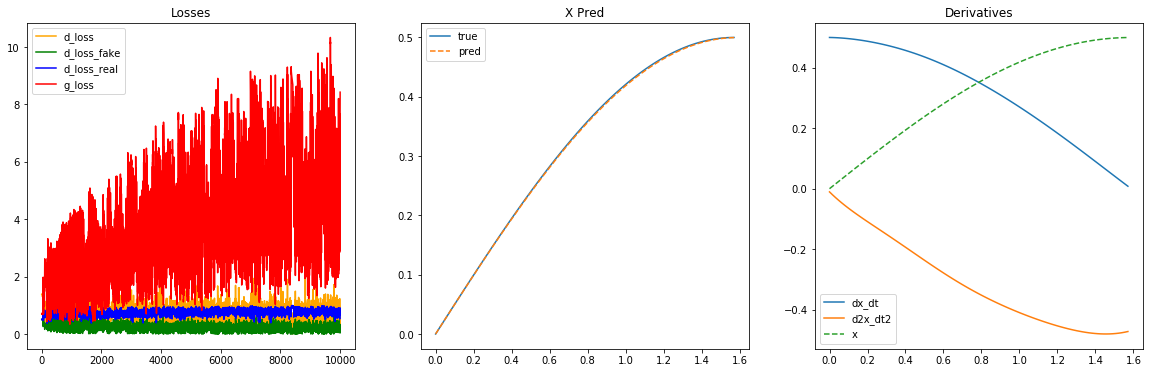

CPU times: user 4min 23s, sys: 45.6 s, total: 5min 8s
Wall time: 4min 26s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Here we are using vector input!

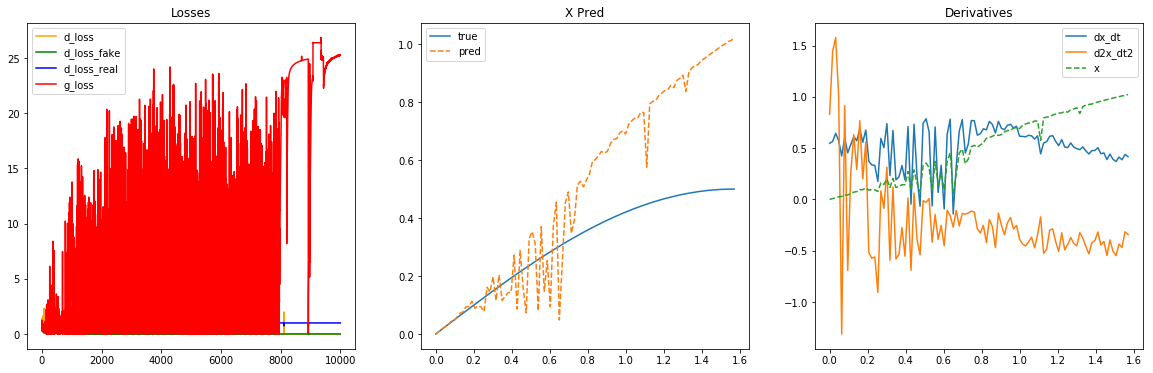

In [0]:
# %%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

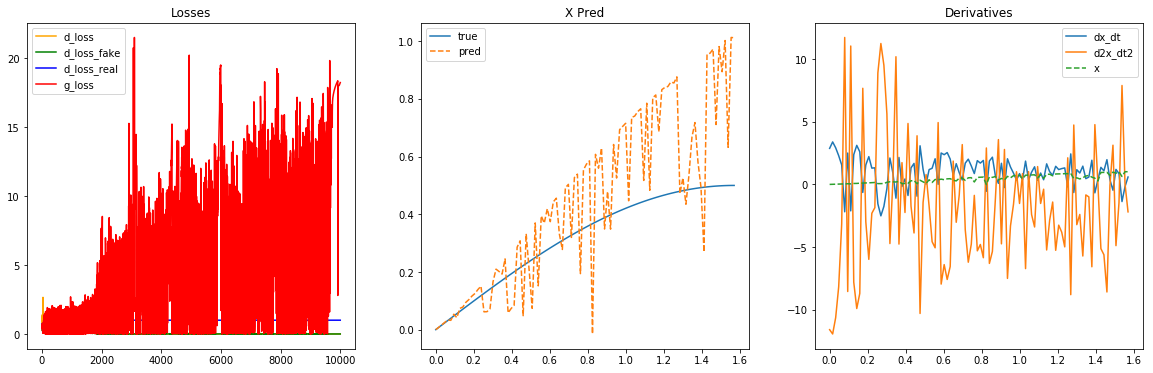

In [0]:
# %%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=100, 
                                  g_hidden_layers=1,
                                  d_hidden_units=100, 
                                  d_hidden_layers=1,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=4,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=1.,

                                  # SYSTEM
                                  systemOfODE=False)

## Using Conditional GAN

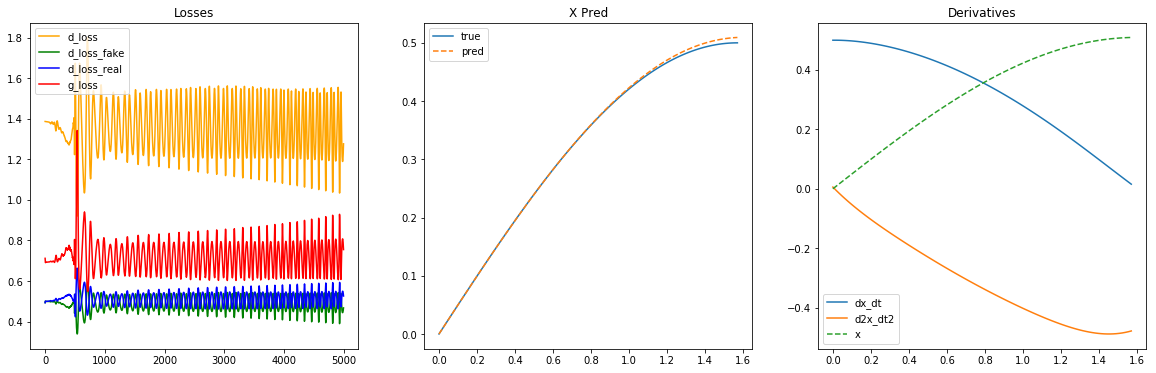

CPU times: user 2min 2s, sys: 20.5 s, total: 2min 22s
Wall time: 2min 4s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  5000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.0001,
                                  g_lr=0.0001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False,
                                  conditionalGAN=True)

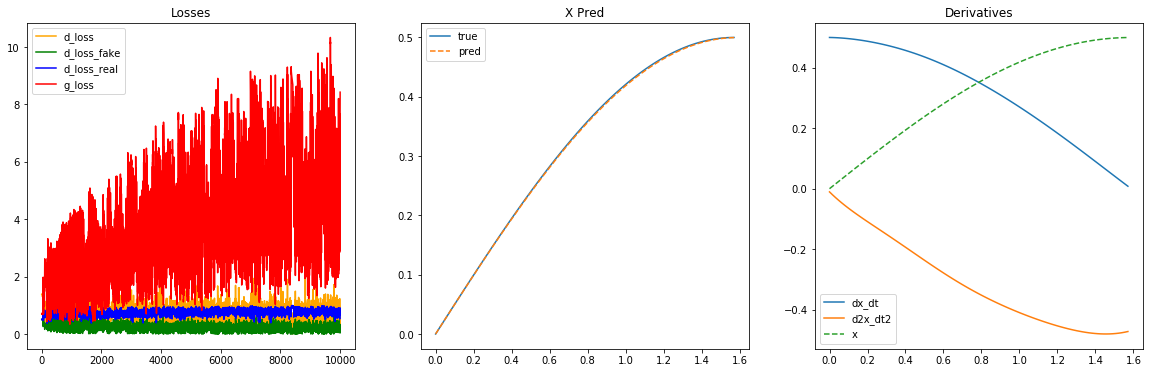

CPU times: user 4min 9s, sys: 45 s, total: 4min 54s
Wall time: 4min 11s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False,
                                  conditionalGAN=True)

## Using Data on (0, $4\pi$)

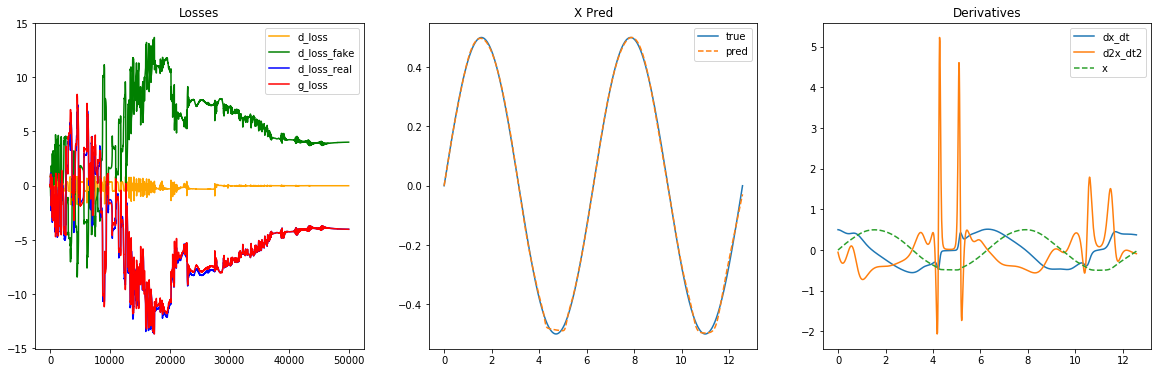

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=True,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

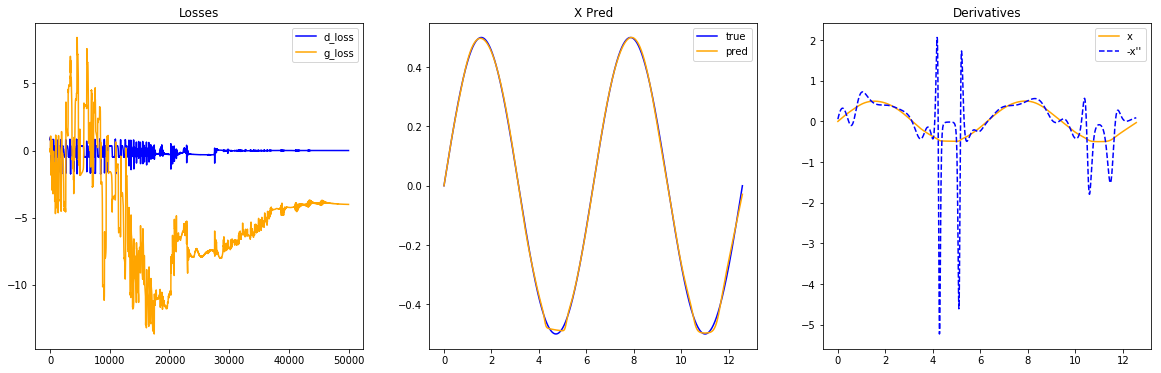

ValueError: ignored

In [14]:
torch.manual_seed(42)
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=True,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

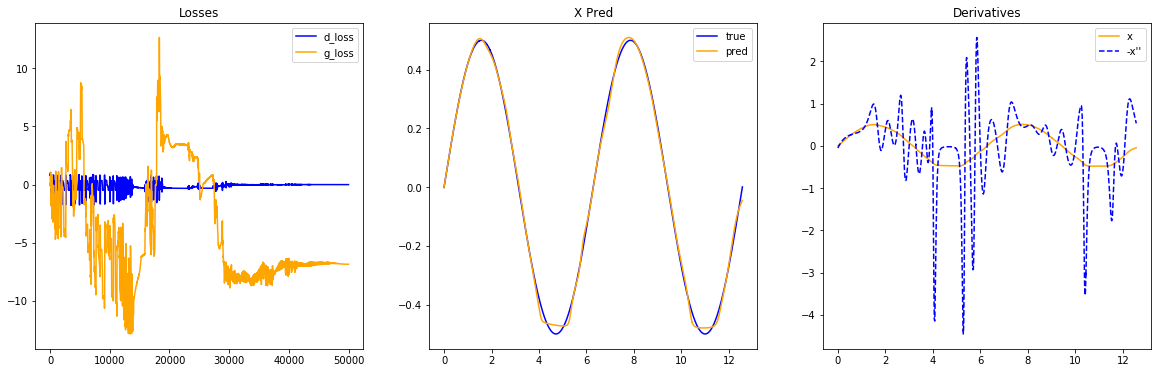

In [17]:
torch.manual_seed(42)
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=True,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

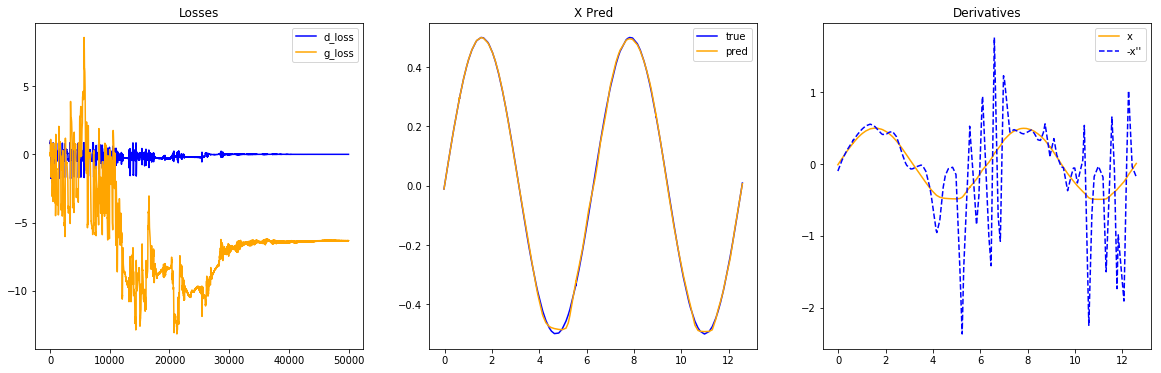

In [18]:
torch.manual_seed(42)
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=True,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

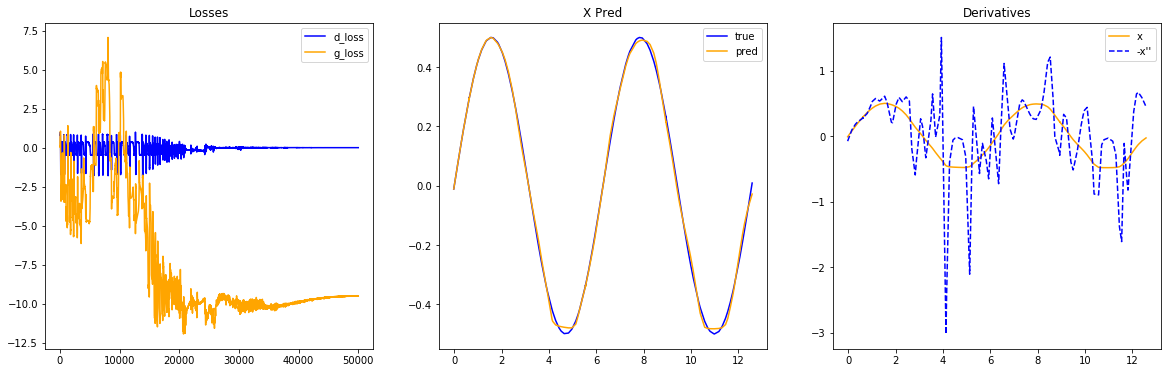

In [19]:
torch.manual_seed(42)
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=20,
  g_hidden_layers=3,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=True,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## Using an MSE (for real data)

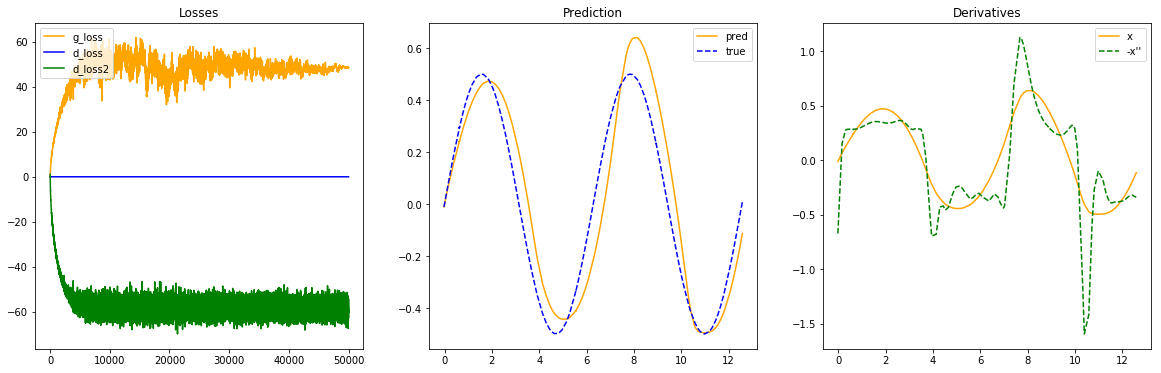

In [11]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## Two D's:

### D: $x, \hat{x}$
### D2: $\hat{x}, -\hat{x}''$

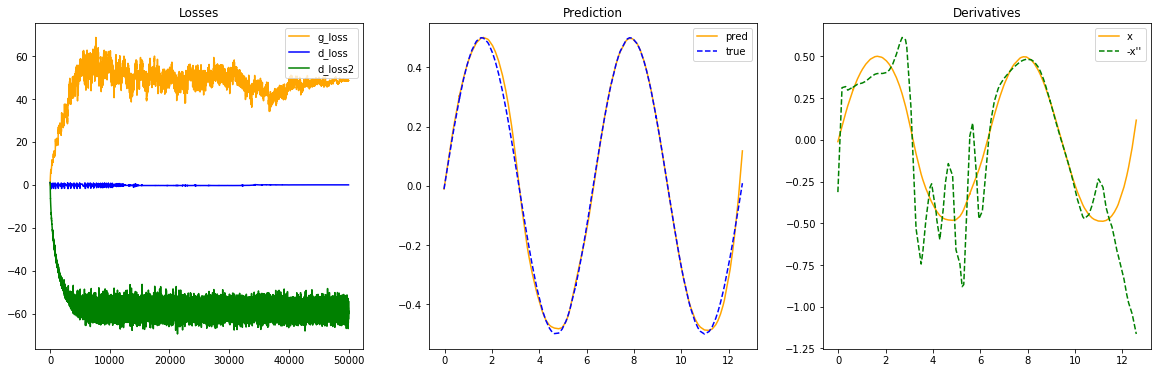

In [55]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

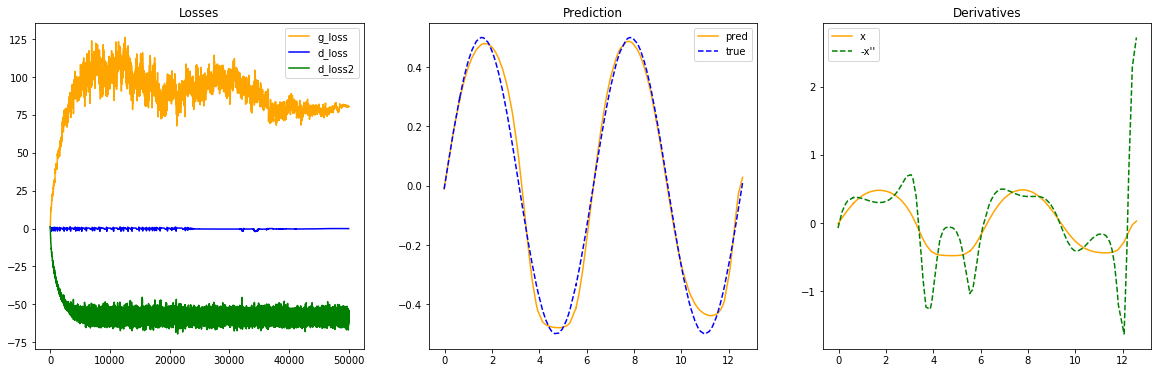

In [57]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=2.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## D2 Hyper = 2x

## Two D's:

### D: $x, \hat{x}$
### D2: $x, -\hat{x}''$

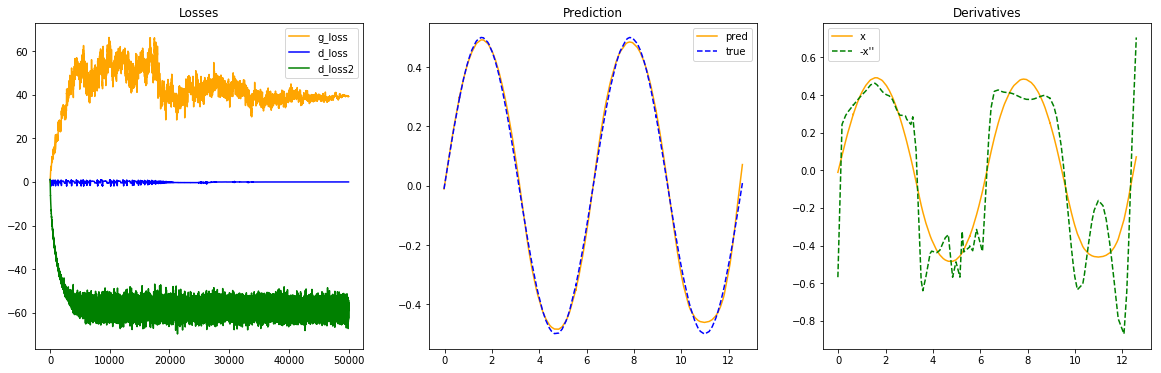

In [47]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

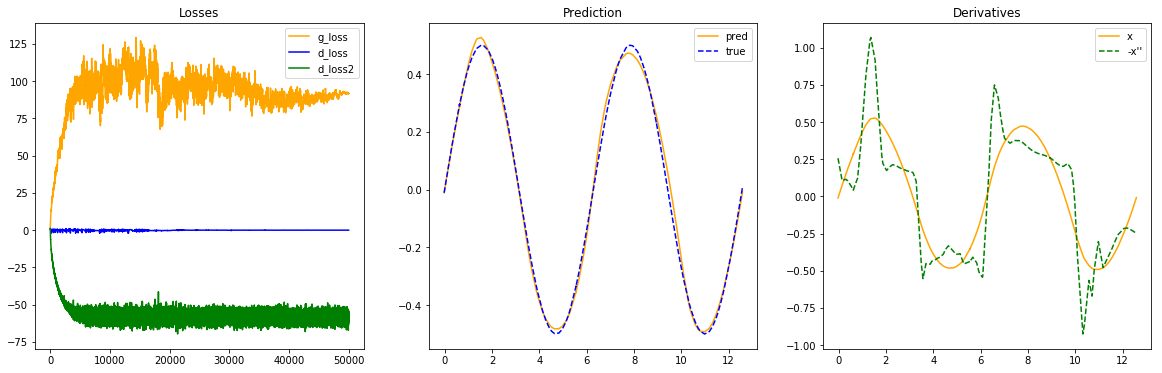

In [6]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=2.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## D2 Hyper = 2x

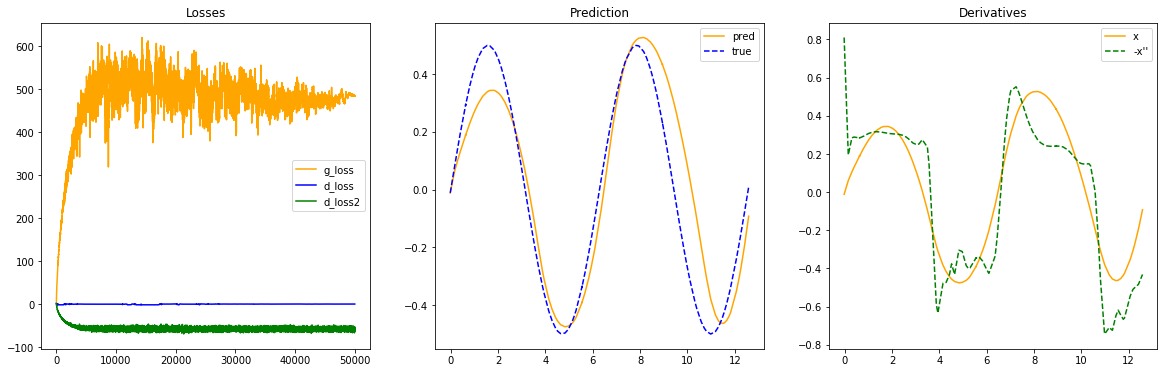

In [7]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=10.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## D2 Hyper = 10

## Residual Connection in G (Two D's, D2 is with Real/Fake2)

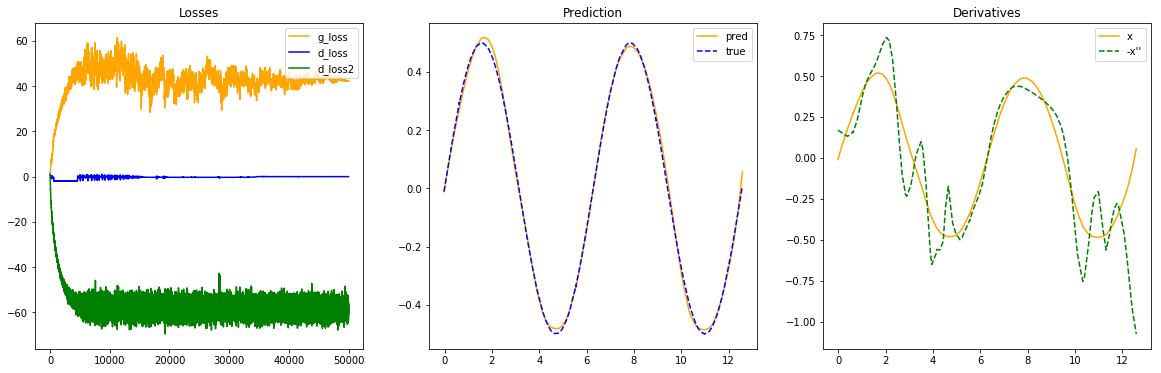

In [55]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  real_data=False,
  wgan=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect 
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

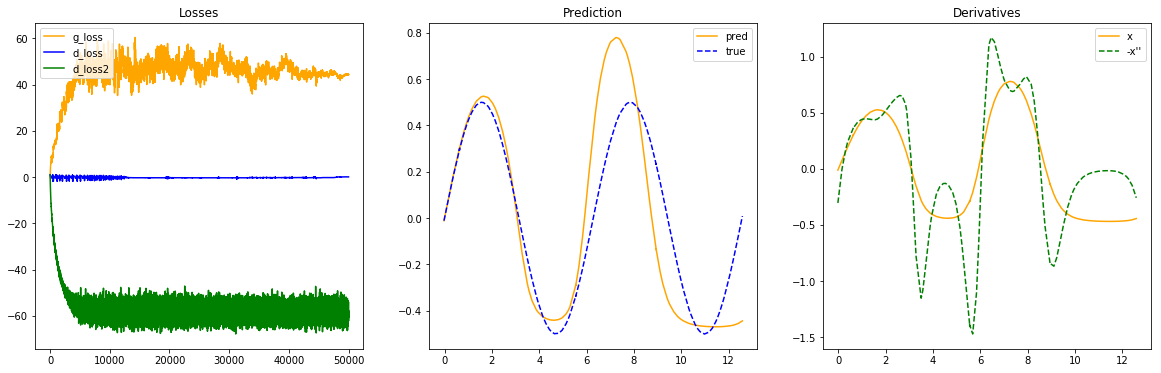

In [56]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=7,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  real_data=False,
  wgan=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect 
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

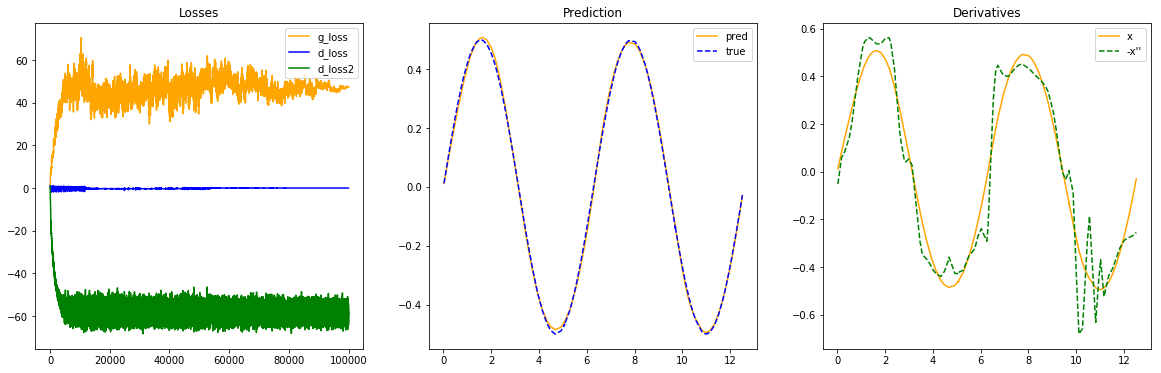

In [57]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=100000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=7,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  real_data=False,
  wgan=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect 
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

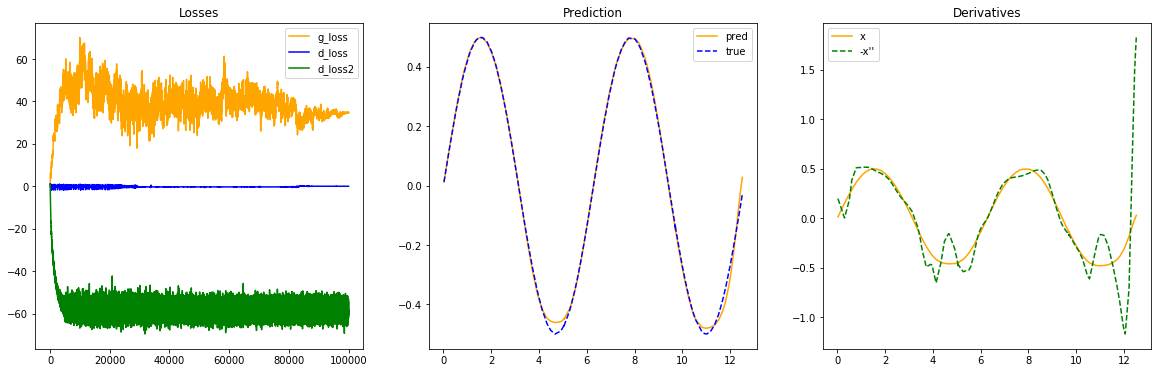

In [58]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=100000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=10,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  real_data=False,
  wgan=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect 
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## Averaging Weights (Exponential Moving)

## Hinge Loss

## One D

### Real ~ x
### Fake ~ x, -x''

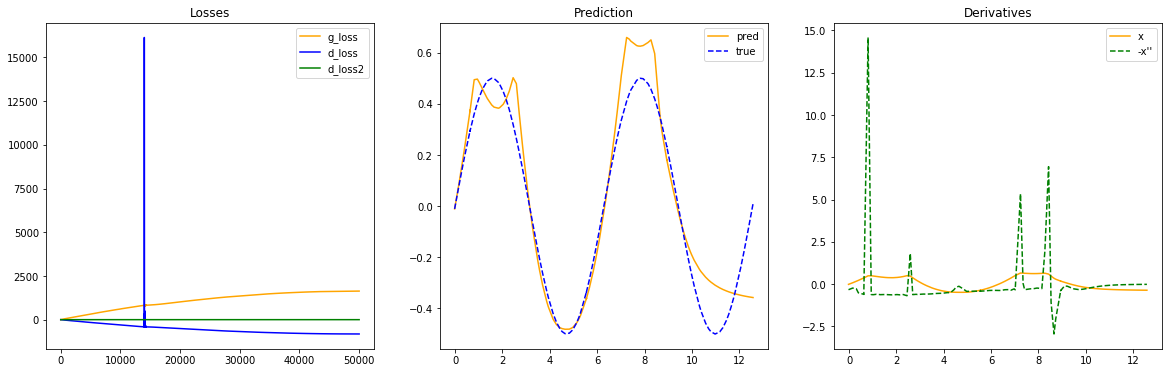

In [5]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

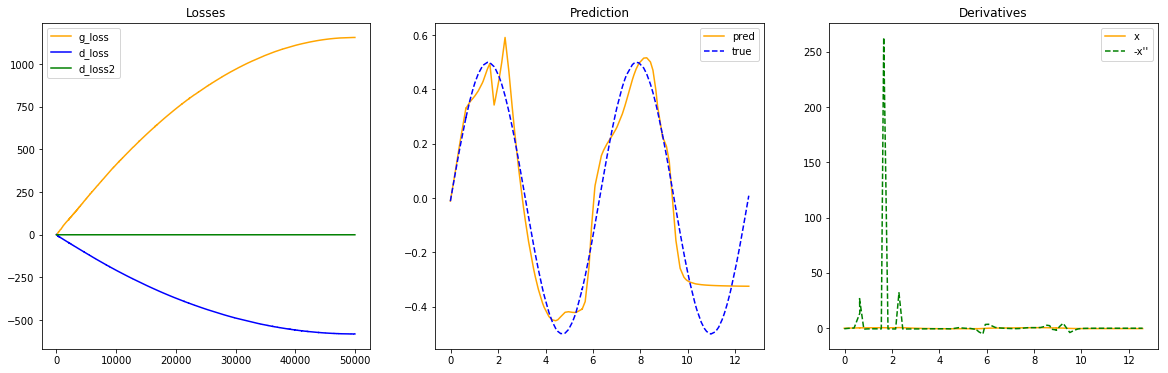

In [6]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=20,
  g_hidden_layers=5,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

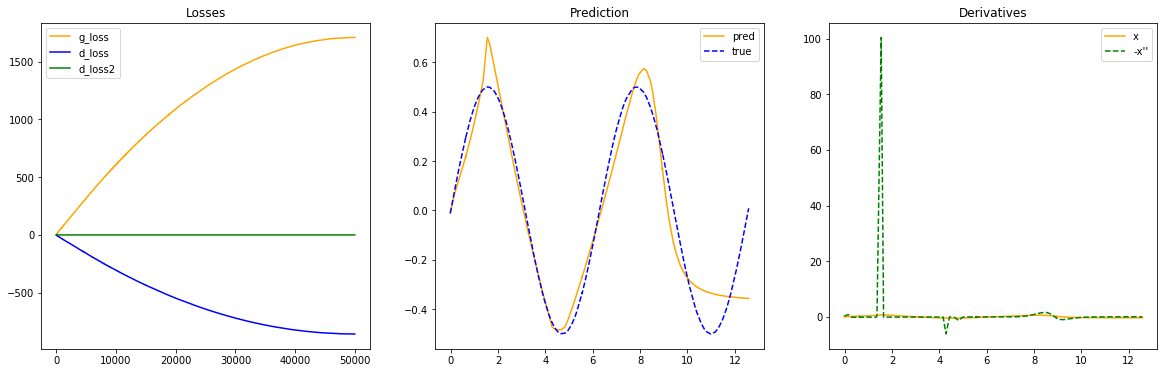

In [7]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=100,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=True,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  d2_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## Semi-Supervised

### Plan 1: L2 loss on generator

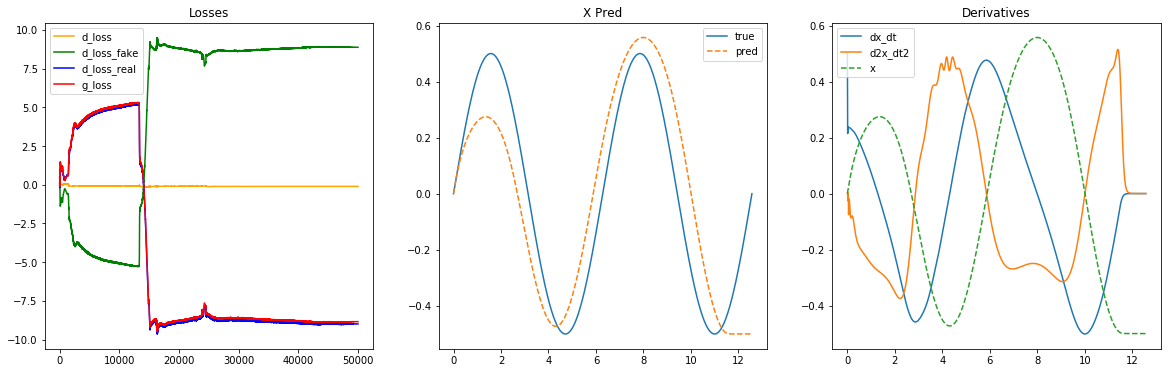

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=20,
  d_hidden_units=20,
  g_hidden_layers=2,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=2, # when observe_every == 1, this is same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

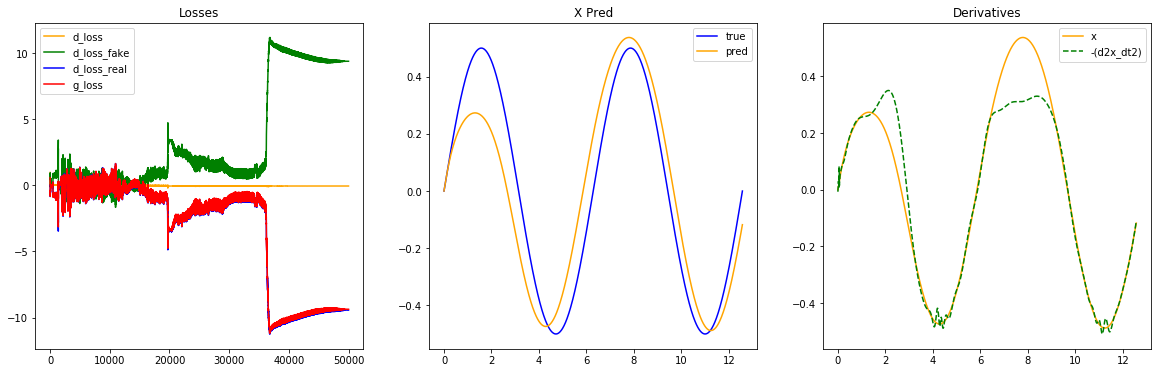

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=2,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

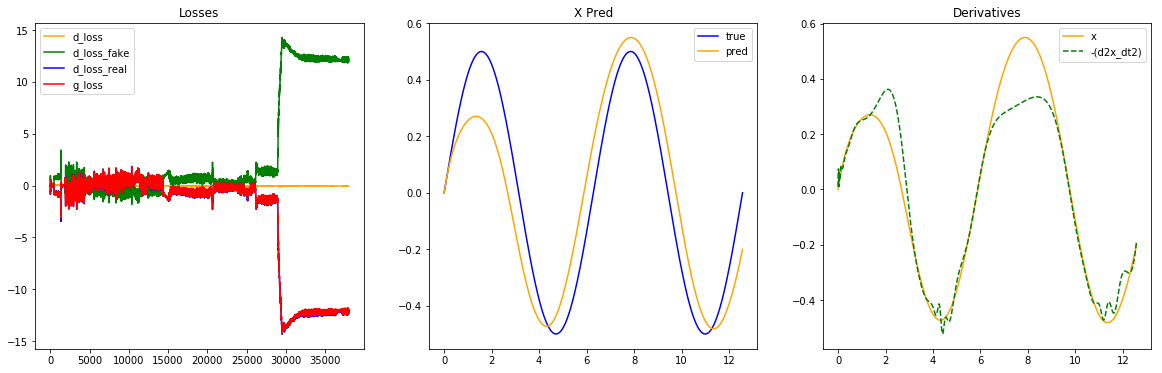

KeyboardInterrupt: ignored

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=2,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

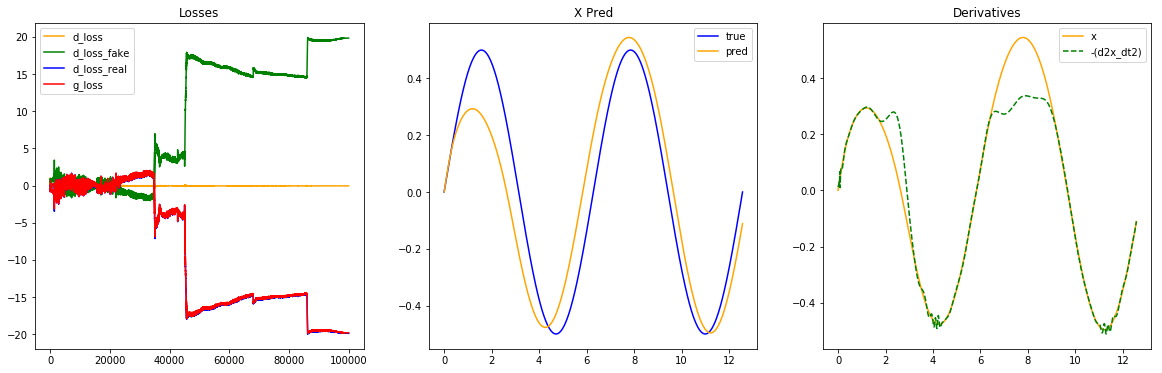

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=100000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=2,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

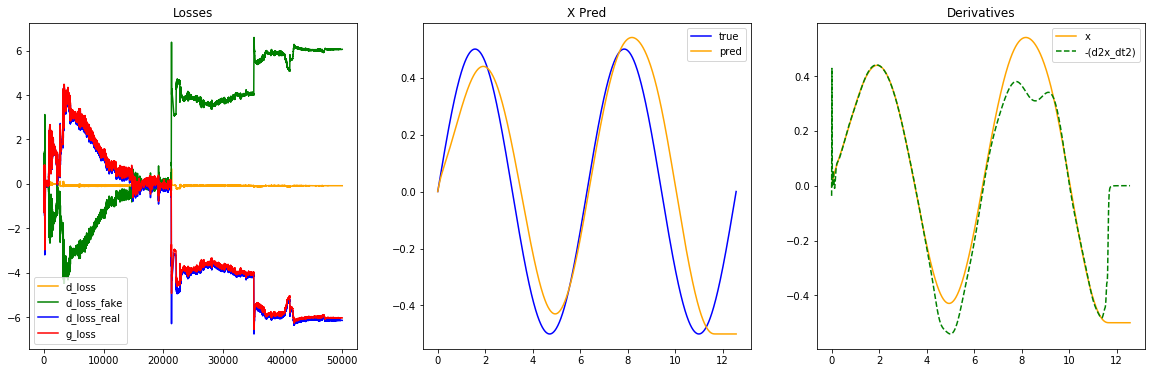

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=50,
  d_hidden_units=30,
  g_hidden_layers=9,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=2,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

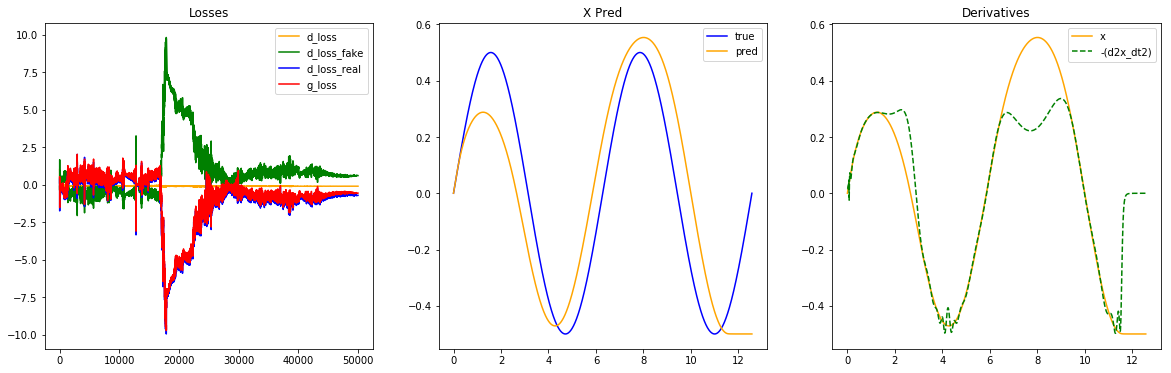

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=50,
  g_hidden_layers=4,
  d_hidden_layers=9,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=2,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

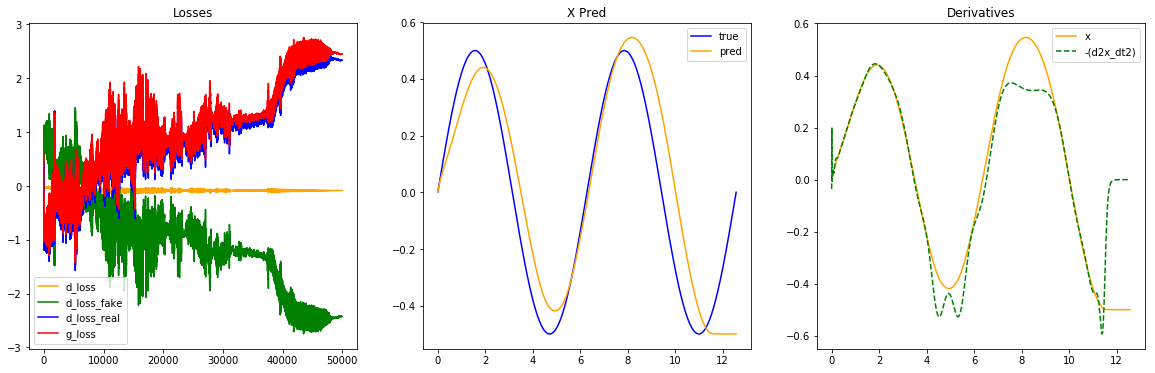

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=20,
  d_hidden_units=50,
  g_hidden_layers=2,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=2,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

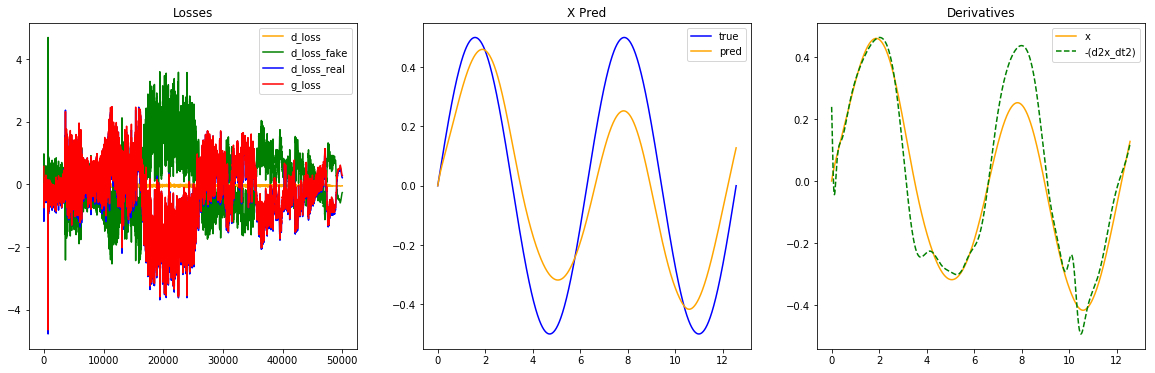

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=5,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

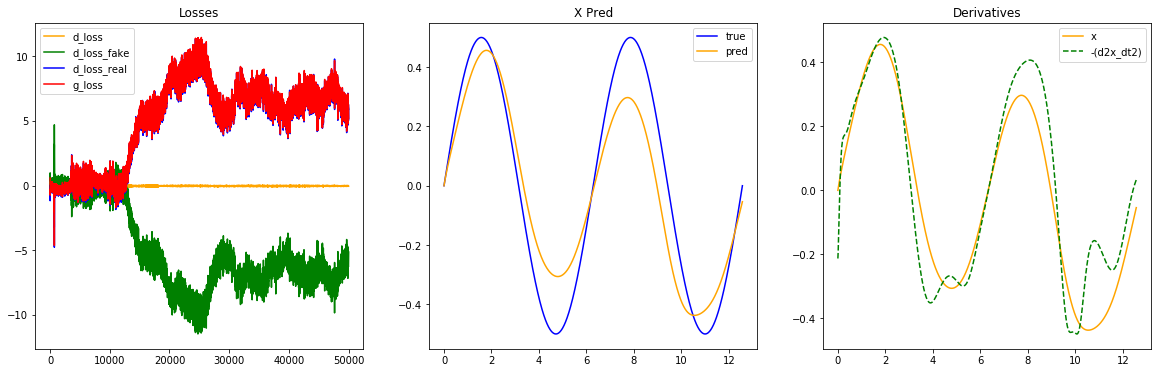

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=5,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=False,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

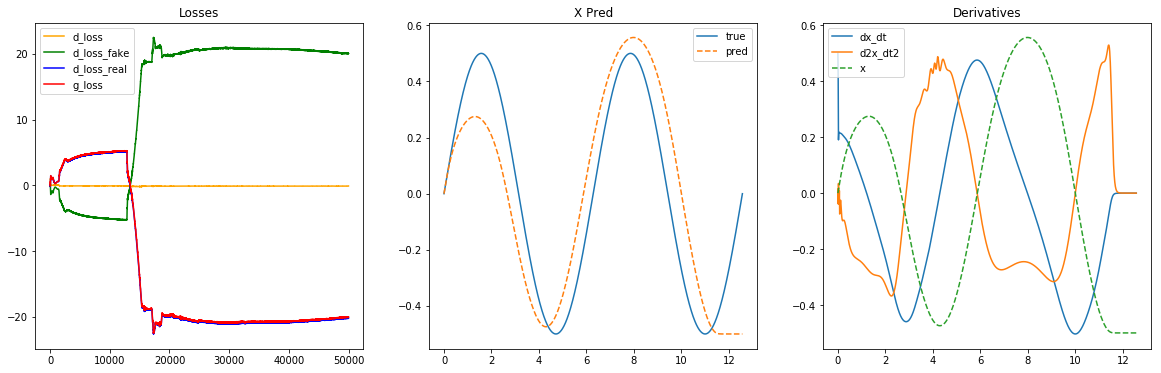

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=20,
  d_hidden_units=20,
  g_hidden_layers=2,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=2, # when observe_every == 1, this is same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=False,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

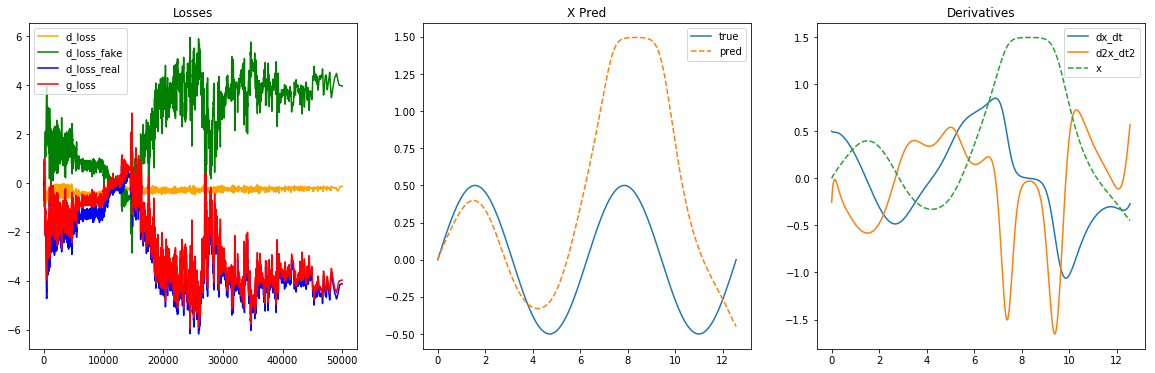

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=2, # when observe_every == 1, this is same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

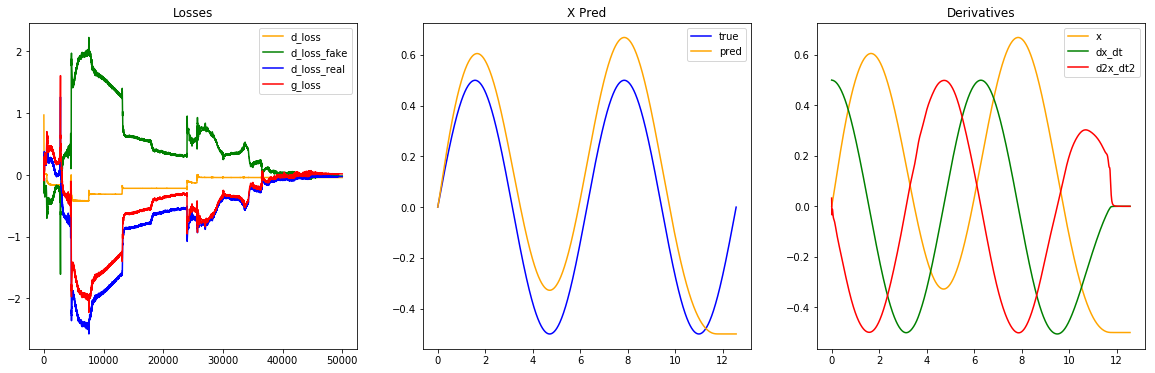

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1, # when observe_every == 1, this is same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

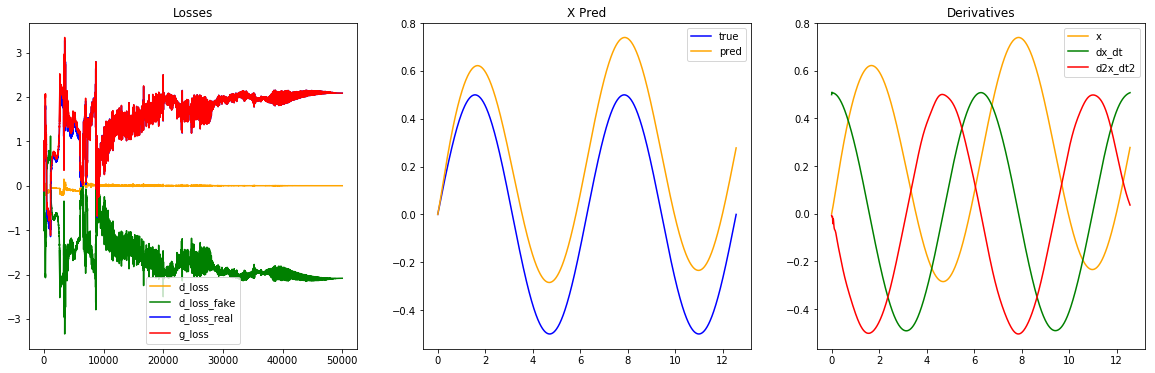

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1, # when observe_every == 1, this is same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

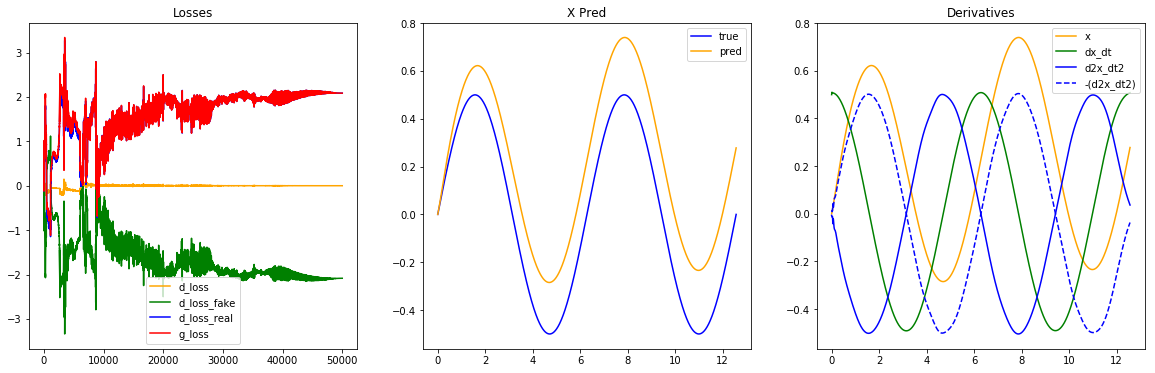

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1, # when observe_every == 1, this is same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

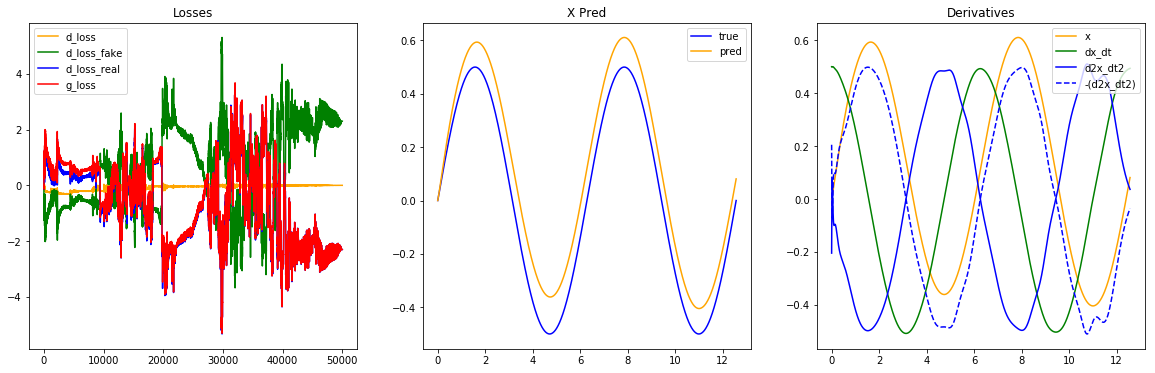

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=4,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1, # when observe_every == 1, this is same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

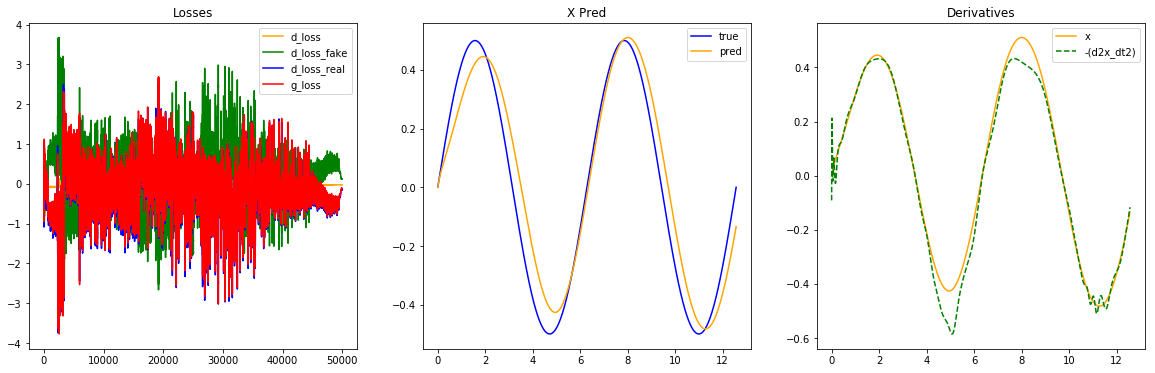

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=20,
  d_hidden_units=30,
  g_hidden_layers=3,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=4,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## Penalize X''

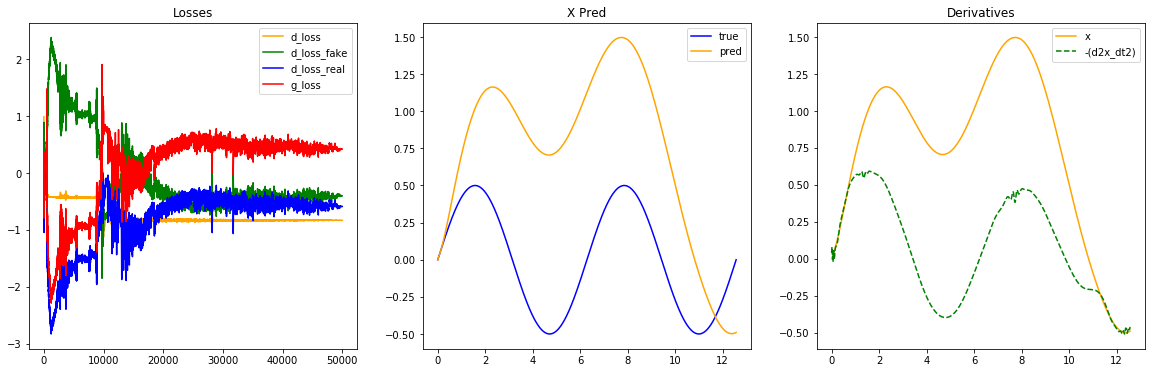

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=20,
  d_hidden_units=30,
  g_hidden_layers=3,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=True,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

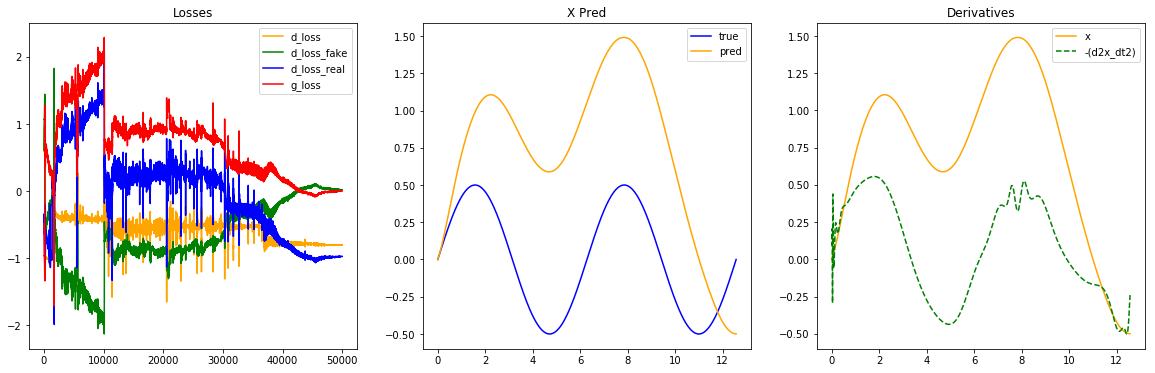

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=5,
  g_hidden_layers=30,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=4,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=True,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

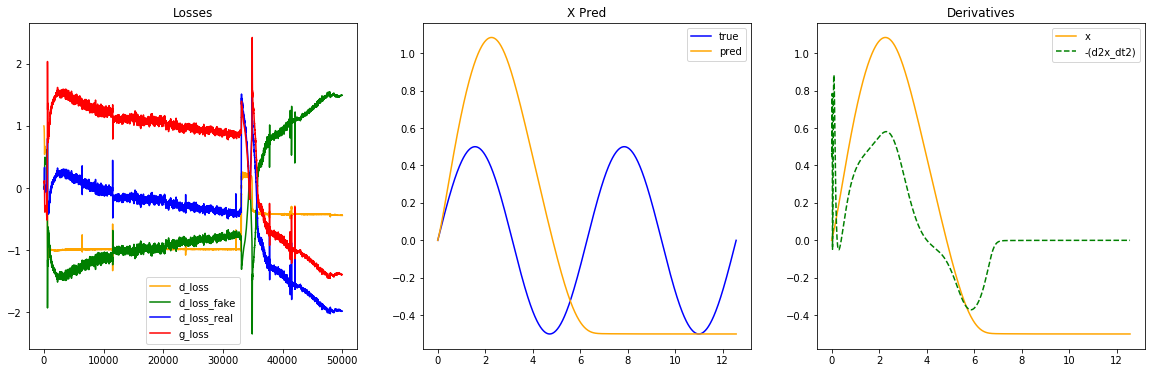

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=5,
  g_hidden_layers=30,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=True,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## Plan 2: Substituting real data into `real`

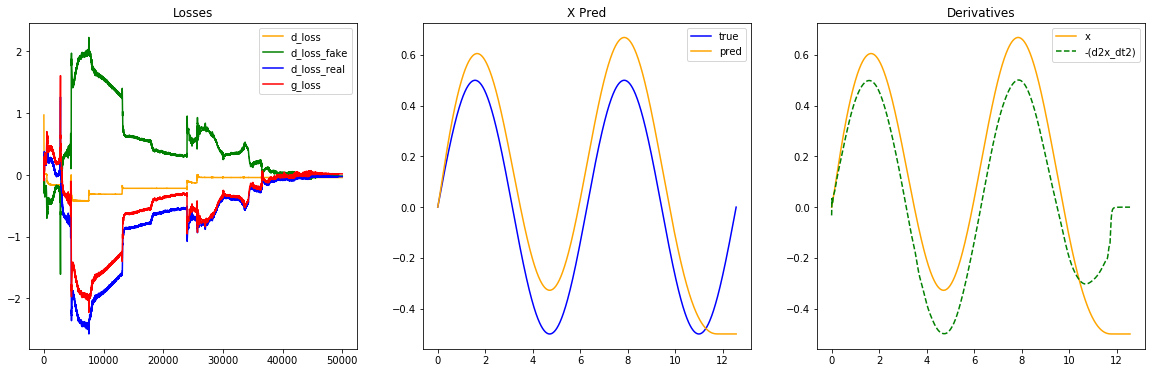

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

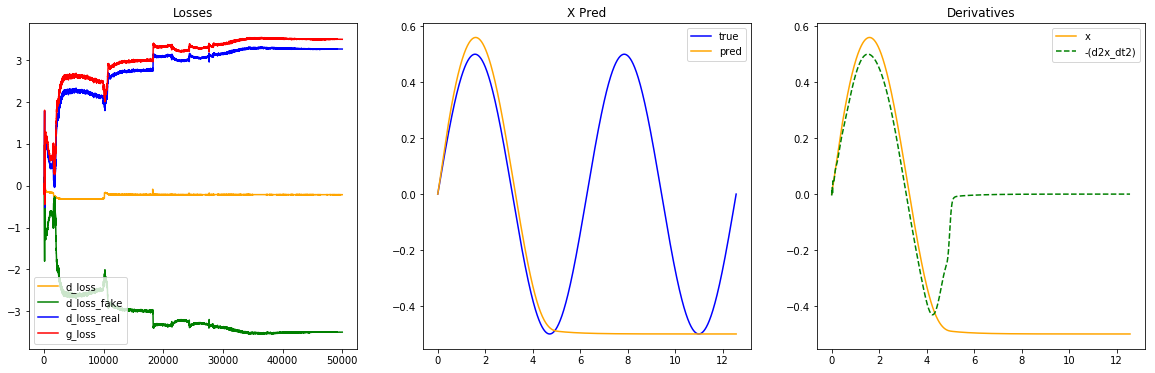

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=20,
  g_hidden_layers=4,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

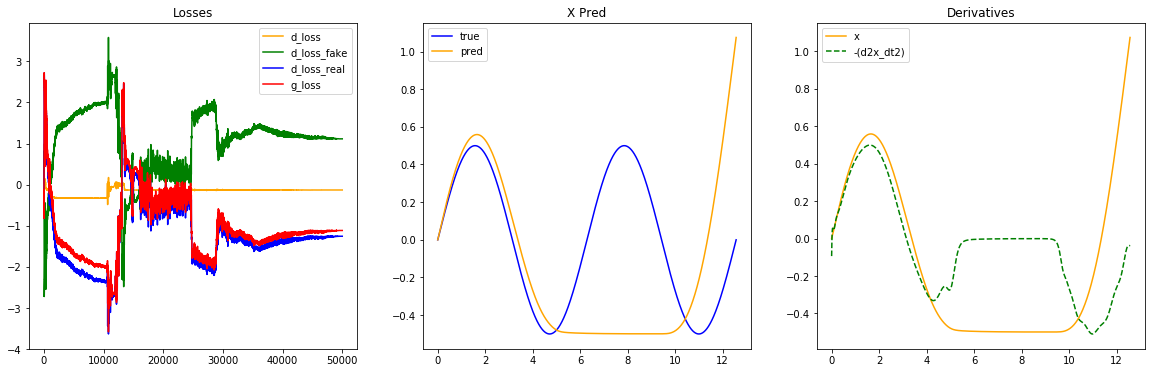

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=20,
  d_hidden_units=30,
  g_hidden_layers=2,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

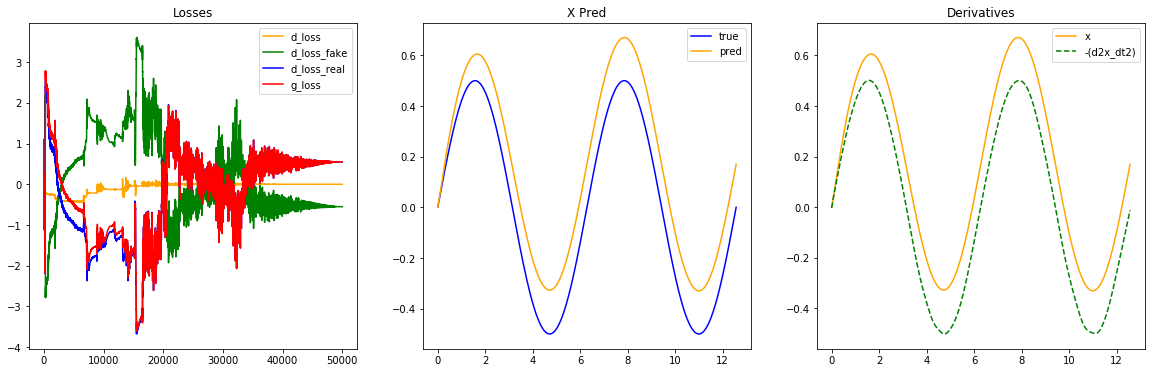

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=4,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

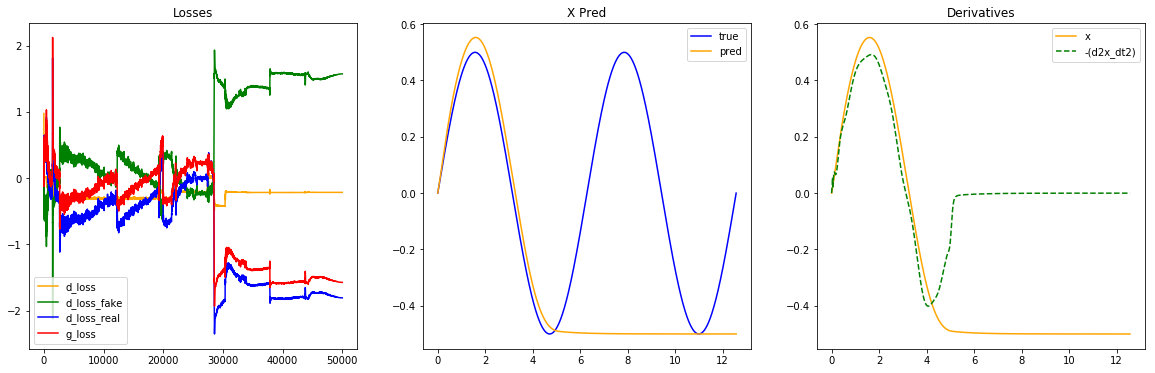

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=50,
  d_hidden_units=50,
  g_hidden_layers=5,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

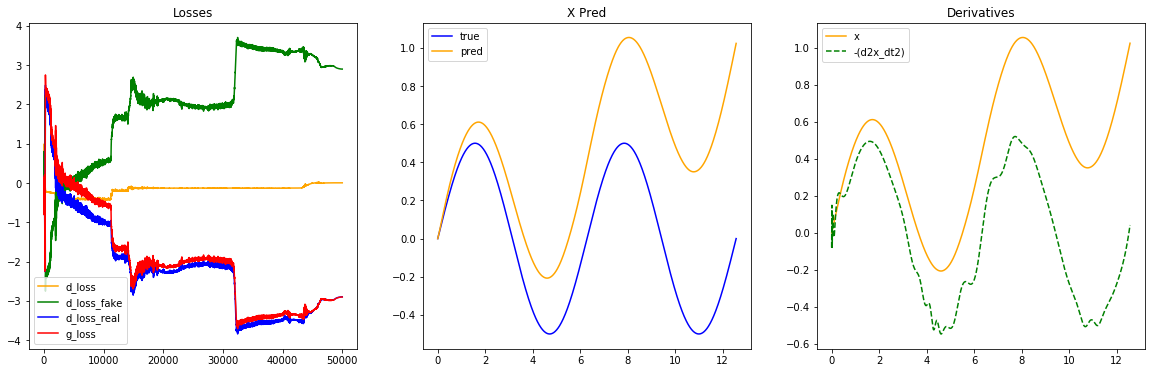

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=4,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

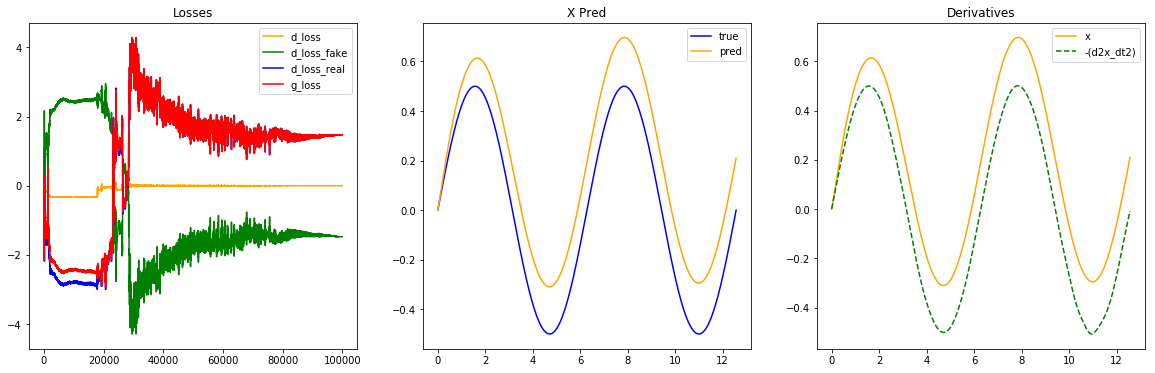

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=100000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=4,
  d_hidden_layers=4,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

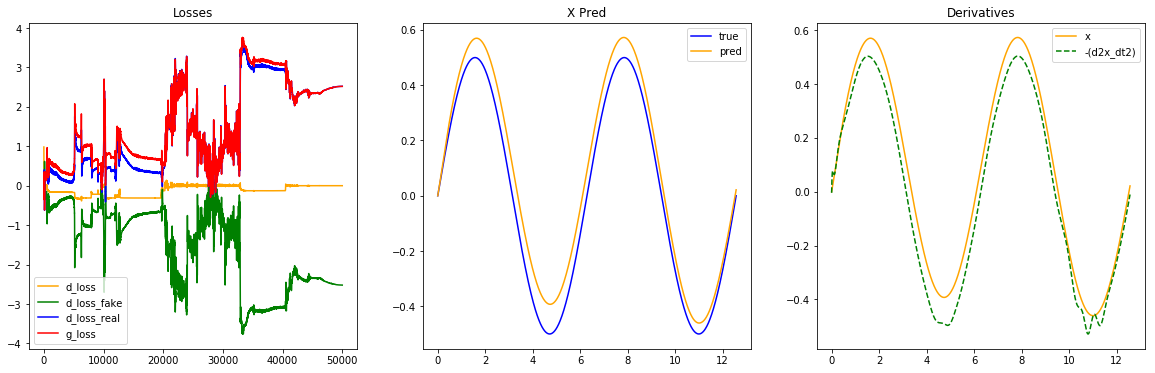

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

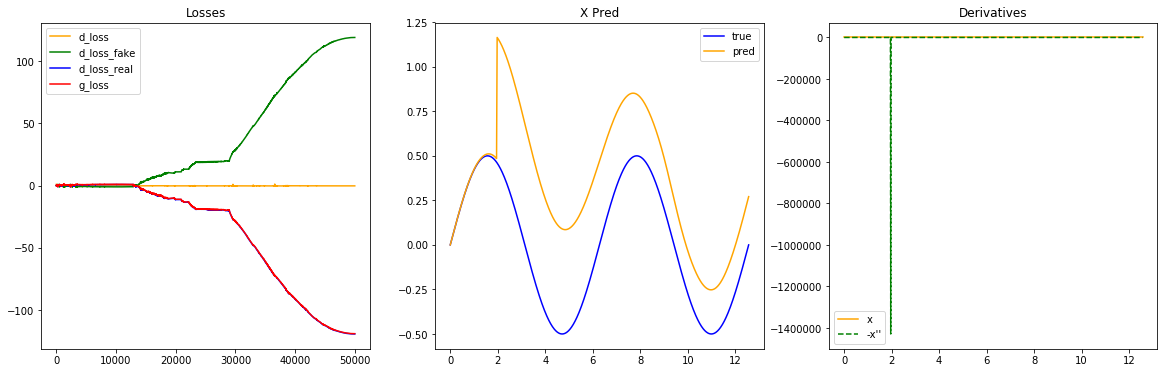

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=6,
  d_hidden_layers=6,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

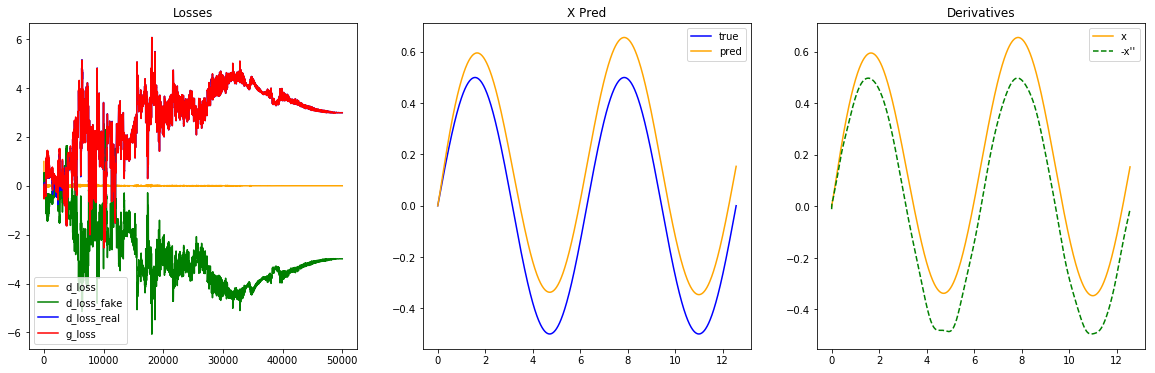

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=6,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

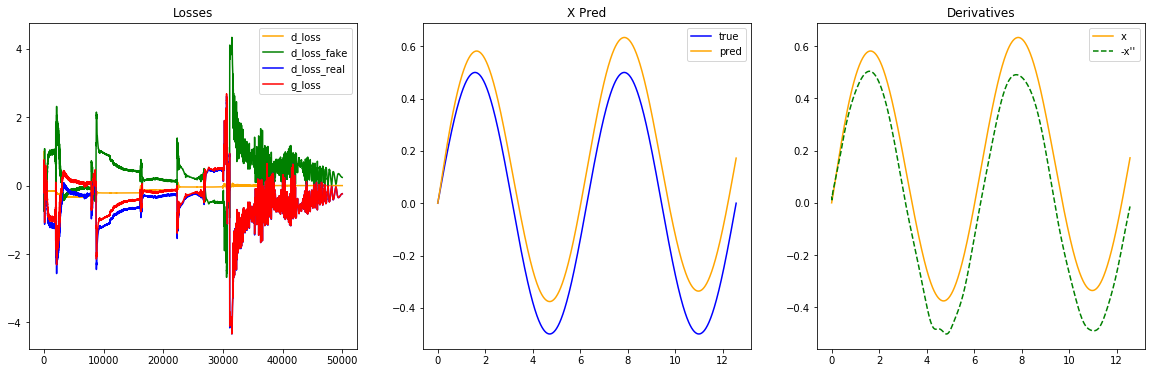

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=6,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

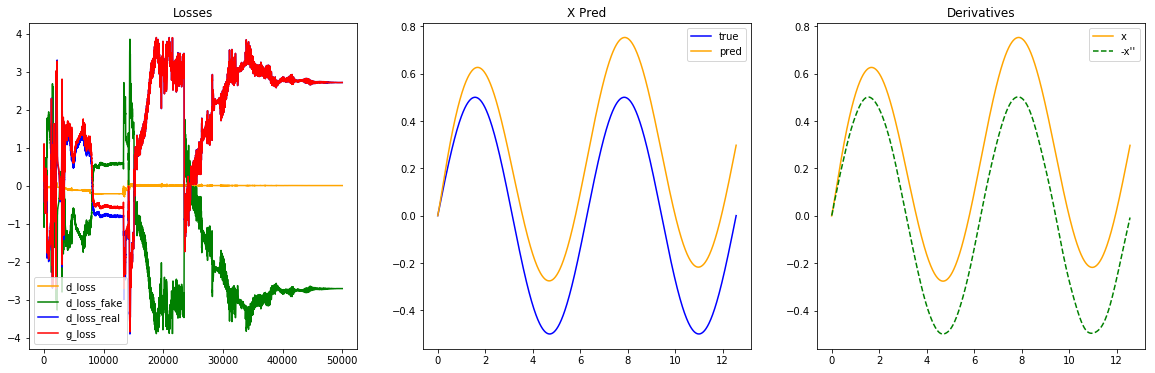

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=7,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

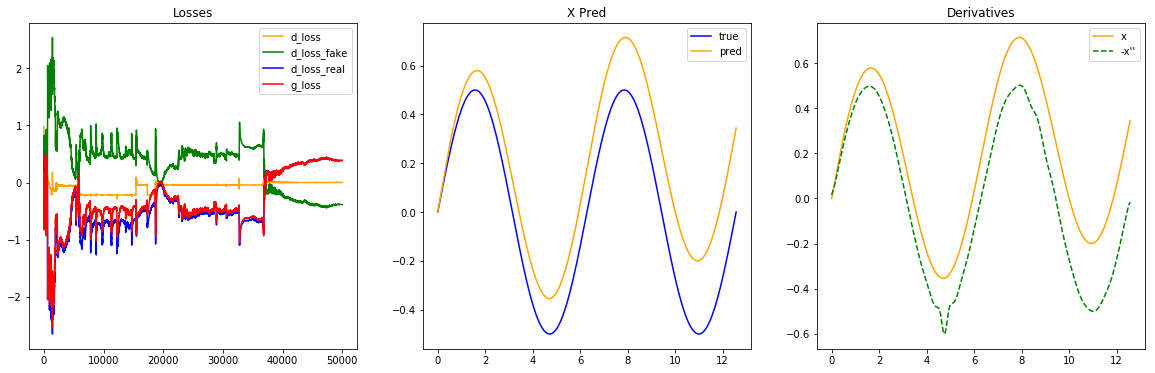

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=4,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

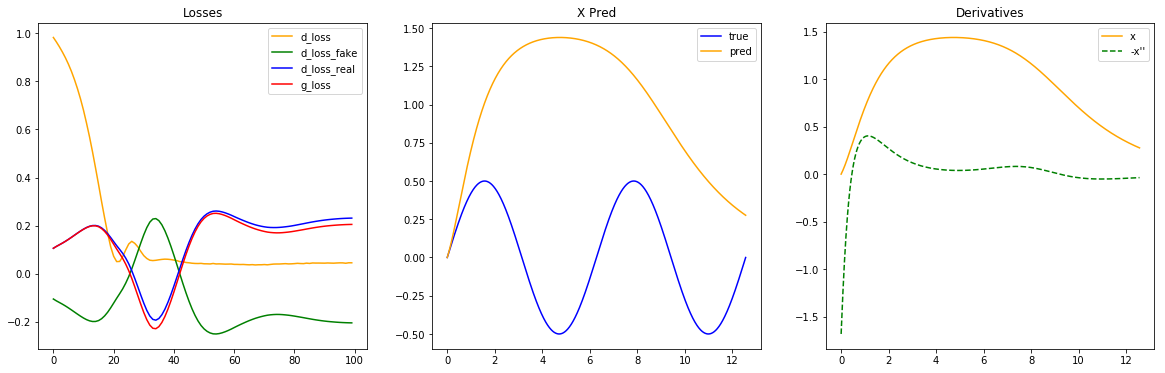

In [0]:
res = train_GAN_SHO(
  # Architecture
  num_epochs=100,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=10,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=False)

## Searching for HPs

In [0]:
def res_mse(res):
  l2 = nn.MSELoss()
  pred = res['G'](res['t'])
  true = res['analytic'](res['t'])
  return l2(pred, true)

In [0]:
def run_exp(dlr, glr, dnunits, gnunits, dnlayers, gnlayers):
  return train_GAN_SHO(
    # Architecture
    num_epochs=5000,
    activation=nn.Tanh(),
    g_hidden_units=gnunits,
    d_hidden_units=dnunits,
    g_hidden_layers=gnlayers,
    d_hidden_layers=dnlayers,
    d_lr=dlr,
    g_lr=glr,
    d_betas=(0.9, 0.999),
    g_betas=(0.9, 0.999),
    G_iters=1,
    D_iters=1,
    # Problem
    t_low=0,
    t_high=4*np.pi,
    x0=0,
    dx_dt0=.5,
    n=1000,
    m=1.,
    k=1.,
    real_label=1,
    fake_label=0,
    # Hacks
    perturb=False,
    soft_labels=False,
    real_data=False,
    semi_supervised=True,
    plan1=False,
    observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
    wgan=True,
    clip=.1,
    gradient_penalty=True,
    gp_hyper=1.,
    outputTan=True,
    systemOfODE=True,
    conditionalGAN=True,
    lr_schedule=False,
    decay_start_epoch=1000,
    # Inspect
    savefig=False,
    fname=None,
    device=None,
    check_every=500,
    logging=False,
    realtime_plot=False)

**Keeping G constant, Edit D**

In [0]:
lrs = [1e-3, 2e-3, 5e-4, 2e-4]
units = [10,20,30,50]
layers = [2,3,4,5]

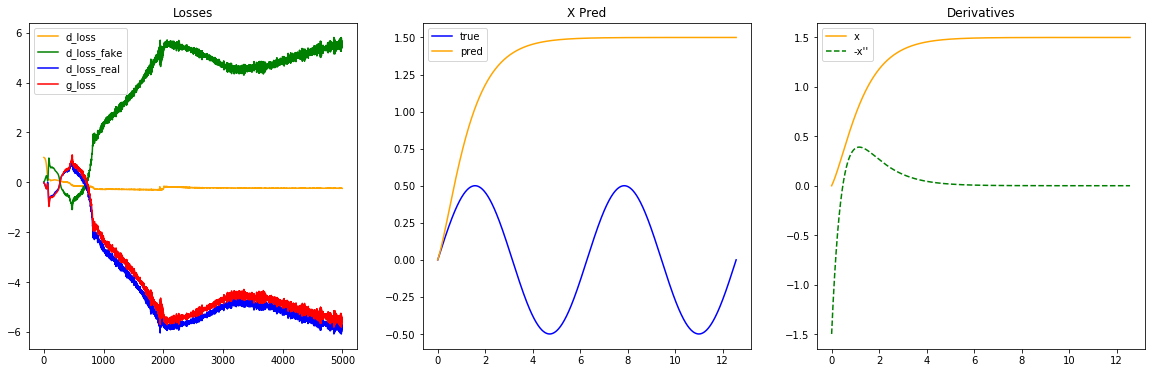

In [0]:
best_mse=float('inf')
best_params=None
best_res=None 
for l in lrs:
  for u in units:
    for la in layers:
      res = run_exp(l, 0.001, u, 30, la, 5)
      mse = res_mse(res)
      if mse < best_mse:
        best_mse = mse
        best_params = {'lr': l, 'n_units': u, 'n_layers': la}
        best_res = res

## Result searching over D with G fixed at 30 units x 5 layers @ 0.001 lr

In [0]:
print('Best params: {}'.format(best_params))

Best params: {'lr': 0.001, 'n_units': 50, 'n_layers': 2}


## Keep D constant, edit G

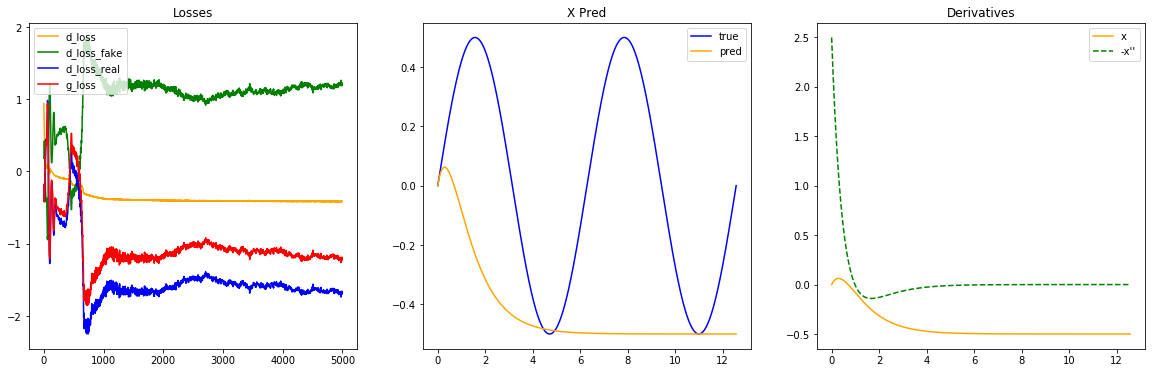

Best params: {'n_units': 30, 'n_layers': 5}


In [0]:
best_mse=float('inf')
best_params=None
best_res=None
for u in units:
  for l in layers:
    print('')
    # dlr, glr, dnunits, gnunits, dnlayers, gnlayers
    res = run_exp(0.001, 0.001, 50, u, 2, l)
    mse = res_mse(res)
    if mse < best_mse:
      best_mse = mse
      best_params = {'n_units': u, 'n_layers': l}
      best_res = res
      print('Best so far: {} with {}'.format(best_mse, best_params))
print('Best params: {}'.format(best_params))

## Vary both of them (4^4)

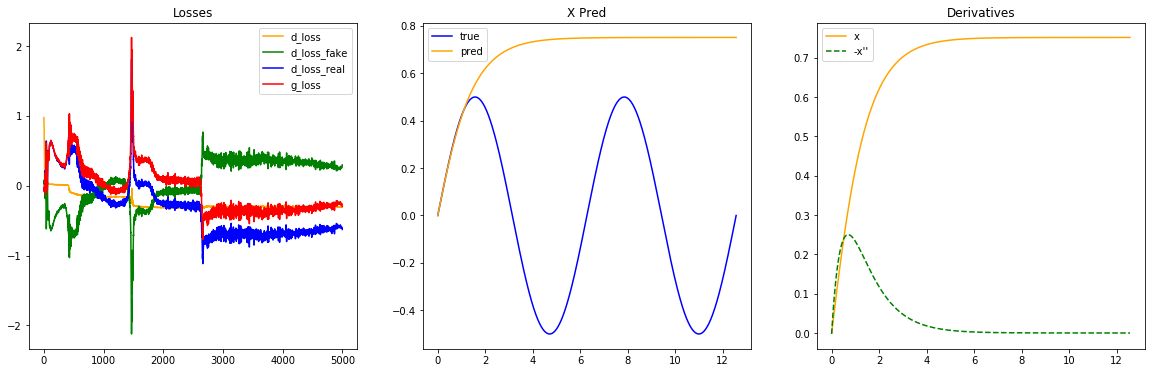

Best params: {'d_units': 50, 'd_layers': 2, 'g_units': 30, 'g_layers': 5}


In [0]:
best_mse=float('inf')
best_params=None
best_res=None
for du in units:
  for dl in layers:
    for gu in units:
      for gl in layers:
        # dlr, glr, dnunits, gnunits, dnlayers, gnlayers
        res = run_exp(0.001, 0.001, du, gu, dl, gl)
        mse = res_mse(res)
        if mse < best_mse:
          best_mse = mse
          best_params = {'d_units': du, 'd_layers': dl, 'g_units': gu, 'g_layers': gl}
          best_res = res
          print('Best so far: {} with {}'.format(best_mse, best_params))
print('Best params: {}'.format(best_params))

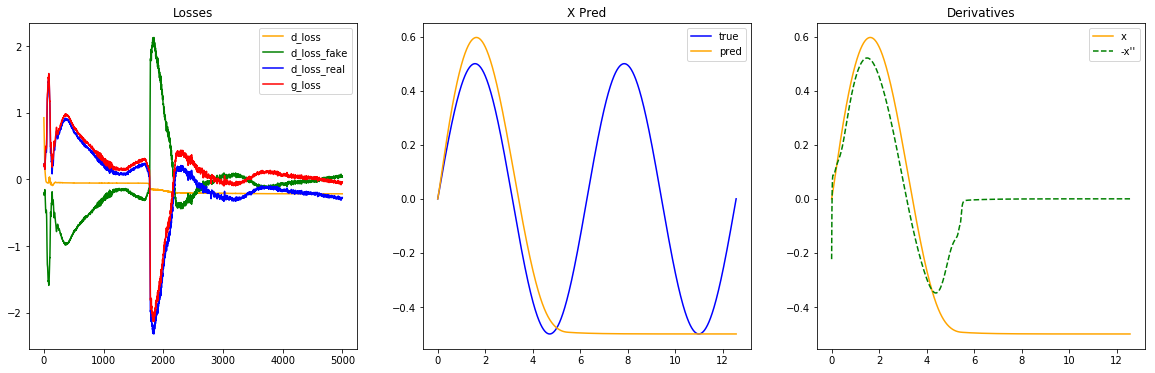

Best params: {'g_units': 30, 'g_layers': 5}


In [0]:
units=[30]
layers=[5,6,7,8]
best_mse=float('inf')
best_params=None
best_res=None
for gu in units:
  for gl in layers:
    # dlr, glr, dnunits, gnunits, dnlayers, gnlayers
    res = run_exp(0.001, 0.001, 50, gu, 2, gl)
    mse = res_mse(res)
    if mse < best_mse:
      best_mse = mse
      best_params = {'g_units': gu, 'g_layers': gl}
      best_res = res
      print('Best so far: {} with {}'.format(best_mse, best_params))
print('Best params: {}'.format(best_params))

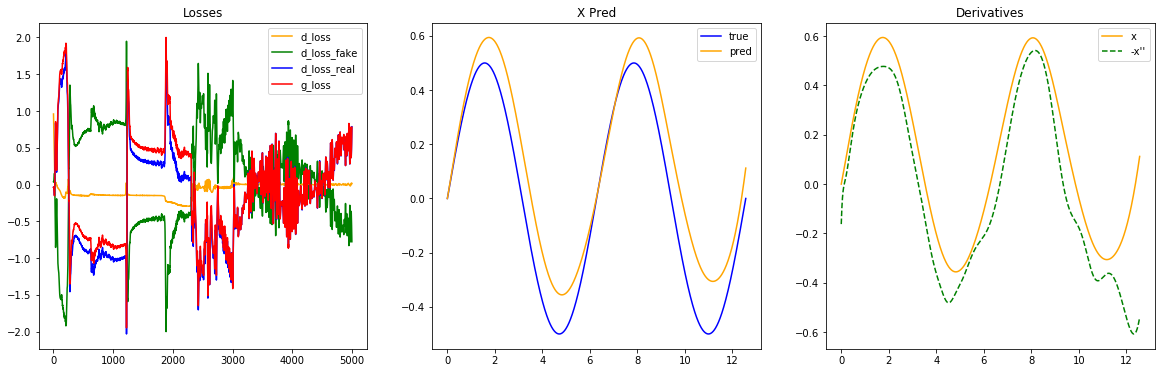

In [0]:
res = train_GAN_SHO(
    # Architecture
    num_epochs=5000,
    activation=nn.Tanh(),
    g_hidden_units=30,
    d_hidden_units=50,
    g_hidden_layers=5,
    d_hidden_layers=2,
    d_lr=0.001,
    g_lr=0.001,
    d_betas=(0.9, 0.999),
    g_betas=(0.9, 0.999),
    G_iters=1,
    D_iters=1,
    # Problem
    t_low=0,
    t_high=4*np.pi,
    x0=0,
    dx_dt0=.5,
    n=1000,
    m=1.,
    k=1.,
    real_label=1,
    fake_label=0,
    # Hacks
    perturb=False,
    soft_labels=False,
    real_data=False,
    semi_supervised=True,
    plan1=False,
    observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
    wgan=True,
    clip=.1,
    gradient_penalty=True,
    gp_hyper=1.,
    outputTan=True,
    systemOfODE=True,
    conditionalGAN=True,
    lr_schedule=False,
    decay_start_epoch=1000,
    # Inspect
    savefig=False,
    fname=None,
    device=None,
    check_every=500,
    logging=False,
    realtime_plot=True)

## Using D on top of real-data vs. X and X vs X''

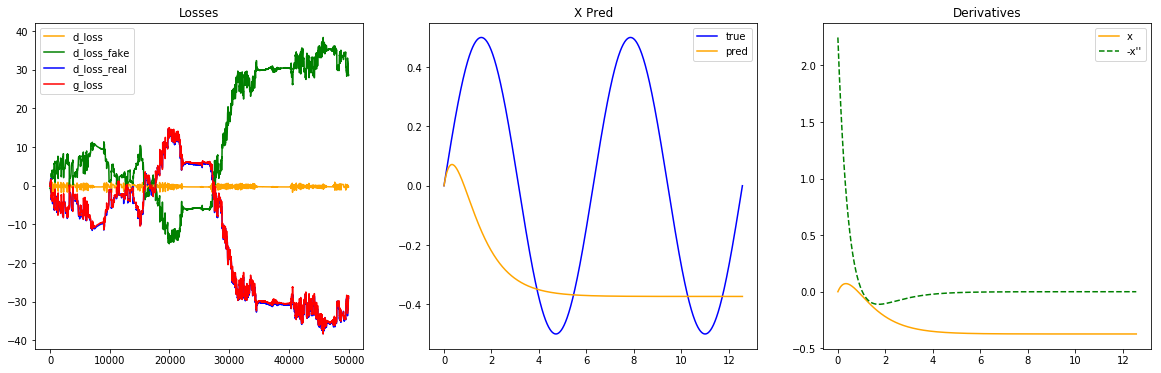

In [0]:
res = train_GAN_SHO(
    # Architecture
    num_epochs=50000,
    activation=nn.Tanh(),
    g_hidden_units=30,
    d_hidden_units=50, #30
    g_hidden_layers=5,
    d_hidden_layers=2, #3
    d_lr=0.001,
    g_lr=0.001,
    d_betas=(0.9, 0.999),
    g_betas=(0.9, 0.999),
    G_iters=1,
    D_iters=1,
    # Problem
    t_low=0,
    t_high=4*np.pi,
    x0=0,
    dx_dt0=.5,
    n=1000,
    m=1.,
    k=1.,
    real_label=1,
    fake_label=0,
    # Hacks
    perturb=False,
    soft_labels=False,
    real_data=False,
    semi_supervised=True,
    plan1=False,
    observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
    wgan=True,
    clip=.1,
    gradient_penalty=True,
    gp_hyper=1.,
    outputTan=True,
    systemOfODE=True,
    conditionalGAN=True,
    lr_schedule=True,
    decay_start_epoch=5000,
    # Inspect
    savefig=False,
    fname=None,
    device=None,
    check_every=500,
    logging=False,
    realtime_plot=True)

## Combining plans

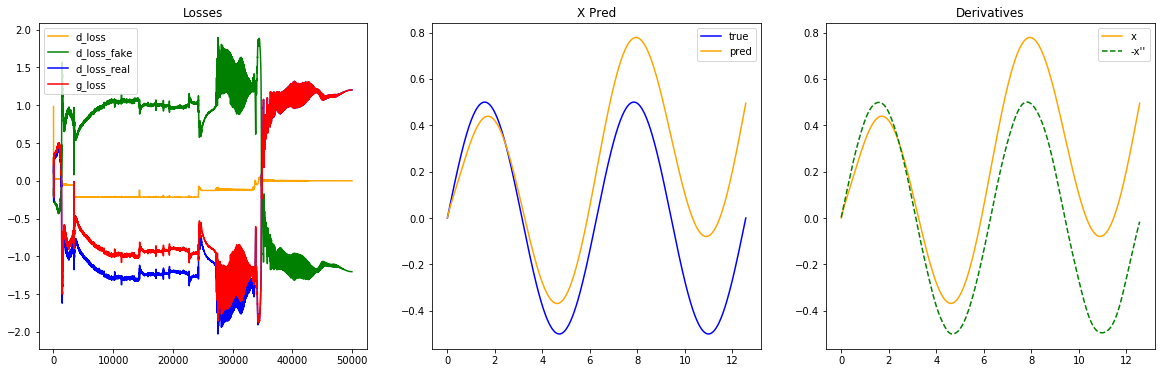

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=1, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## Observers less frequent

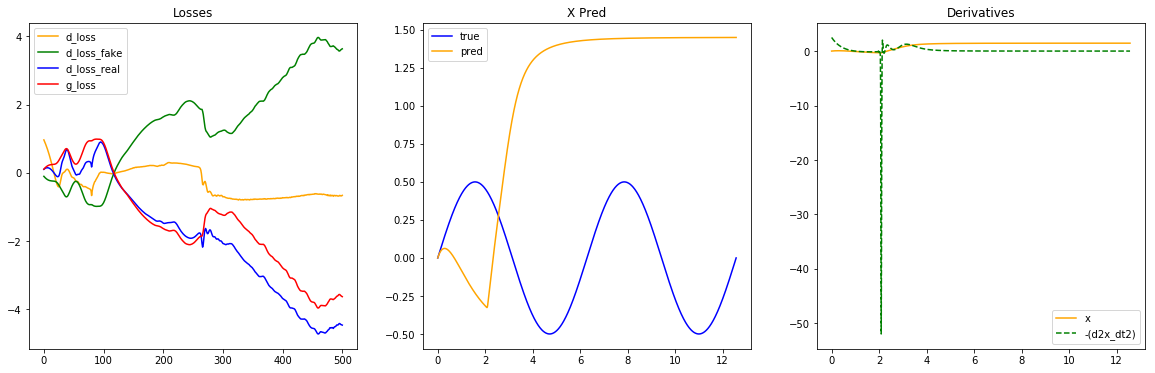

KeyboardInterrupt: ignored

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=2, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=4, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=10, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=30,
  d_hidden_units=30,
  g_hidden_layers=5,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  semi_supervised=True,
  plan1=False,
  observe_every=500, # when observe_every == 1, this is (almost) same as real_data=True
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

## LSTM

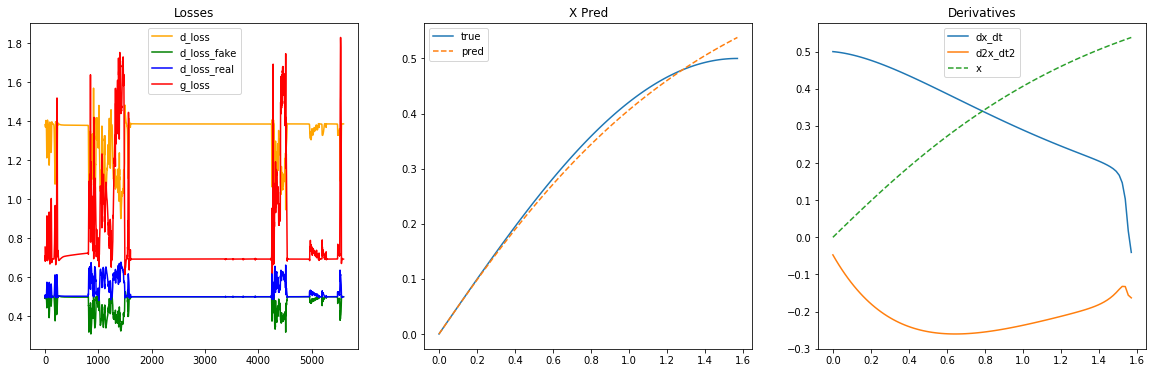

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=1.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Data

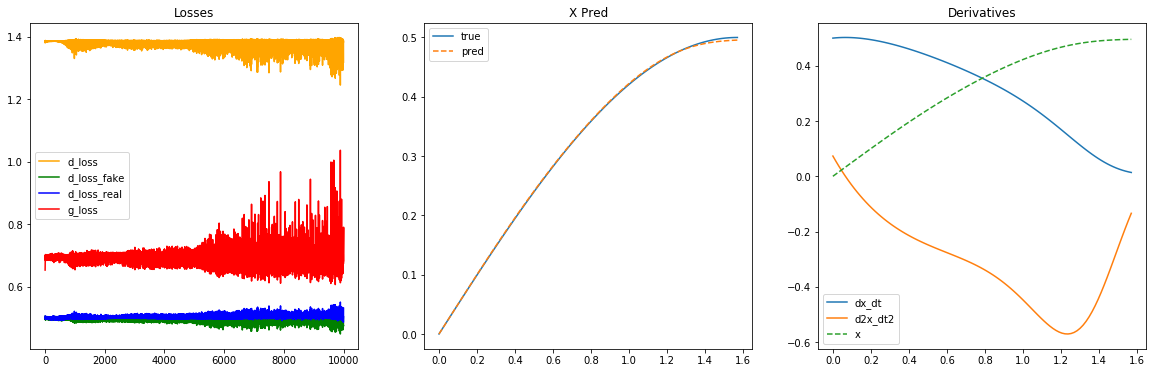

CPU times: user 3min 30s, sys: 42.4 s, total: 4min 12s
Wall time: 3min 31s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.5*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=True,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Fitting on $(0, .6 \pi)$

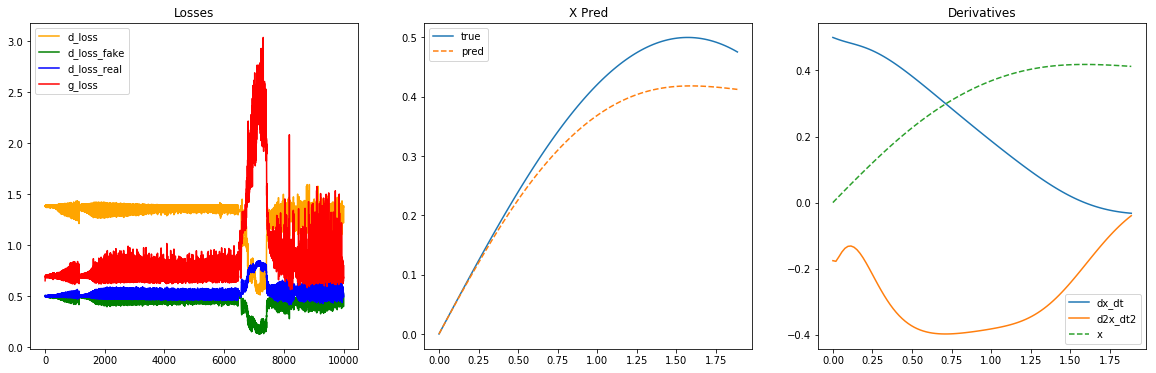

CPU times: user 4min 28s, sys: 45.9 s, total: 5min 14s
Wall time: 4min 32s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

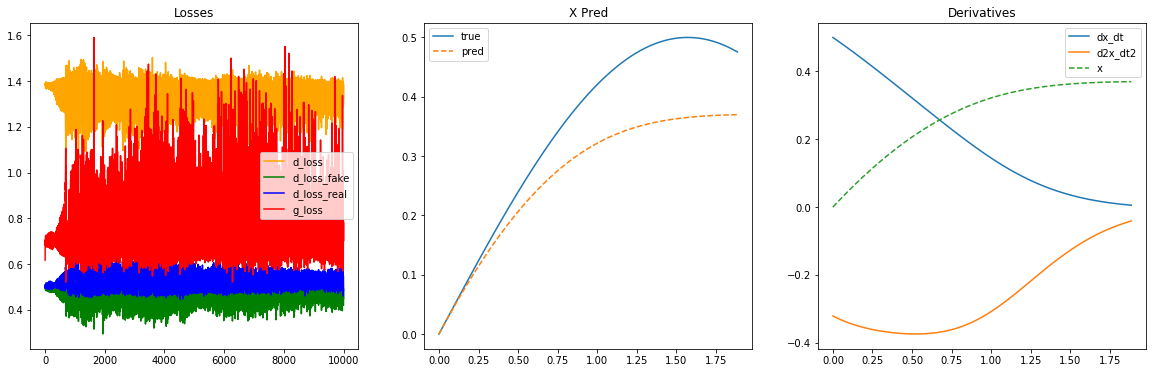

CPU times: user 4min 41s, sys: 48.2 s, total: 5min 29s
Wall time: 4min 44s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

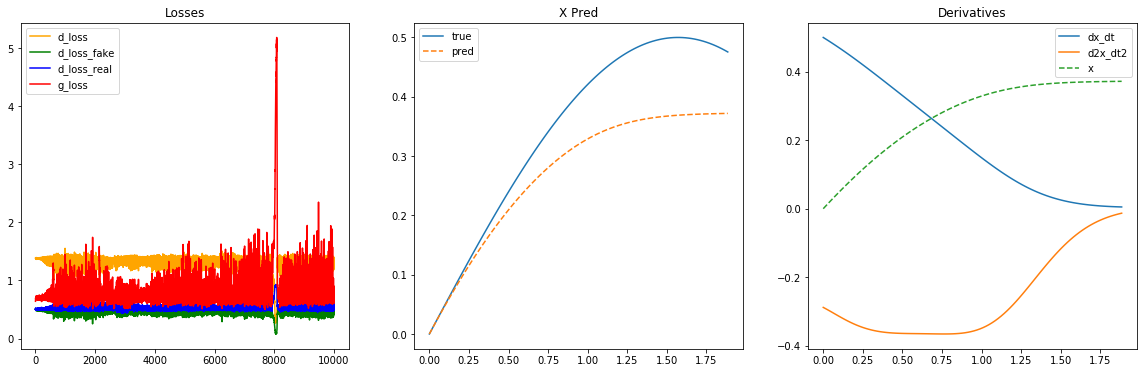

CPU times: user 4min 38s, sys: 47 s, total: 5min 25s
Wall time: 4min 42s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=40, # more node
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

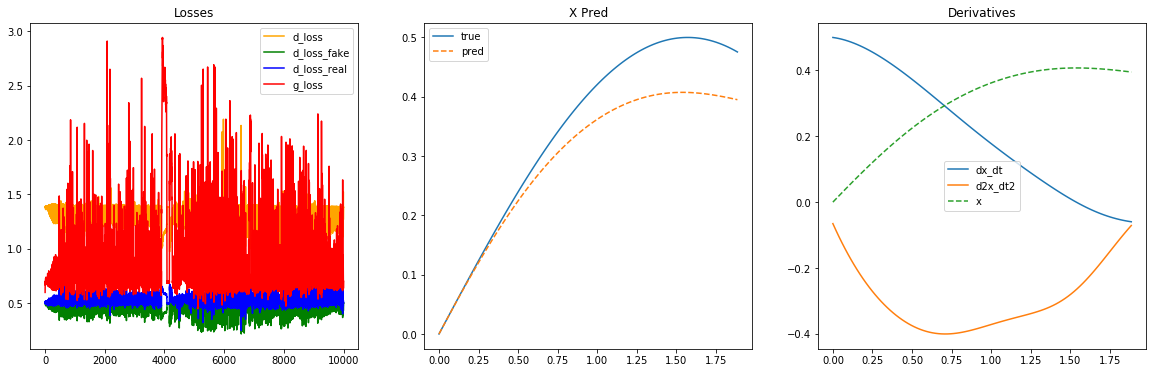

CPU times: user 4min 48s, sys: 46.1 s, total: 5min 34s
Wall time: 4min 53s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

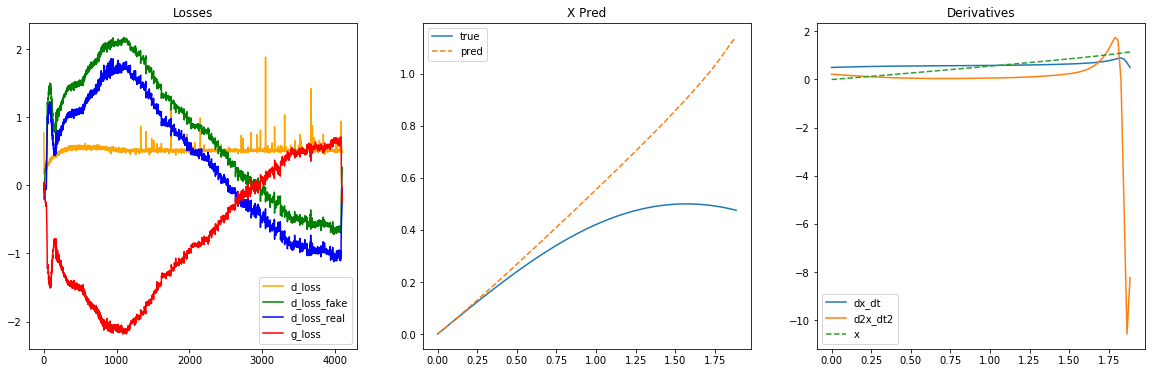

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=True,     # using WGAN
                                  gradient_penalty=True,
                                  gp_hyper=1.,

                                  # SYSTEM
                                  systemOfODE=False)

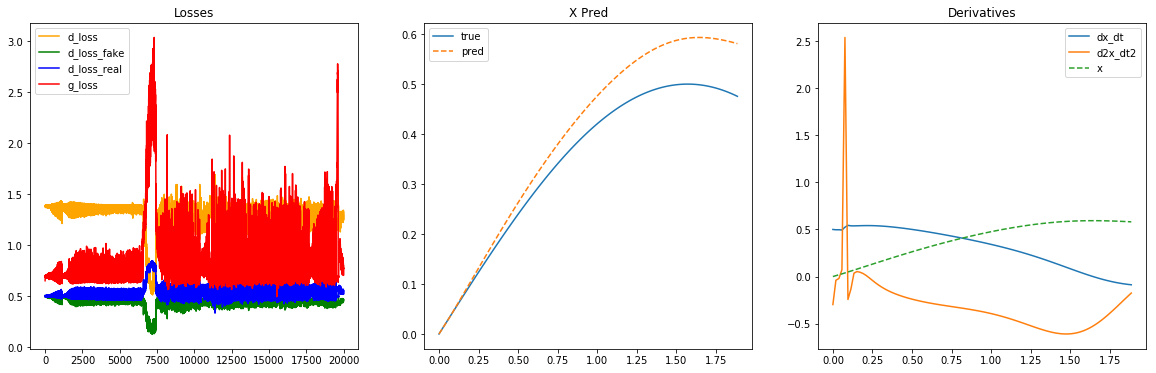

CPU times: user 9min 7s, sys: 1min 35s, total: 10min 42s
Wall time: 9min 13s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  20000,  # more eps

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

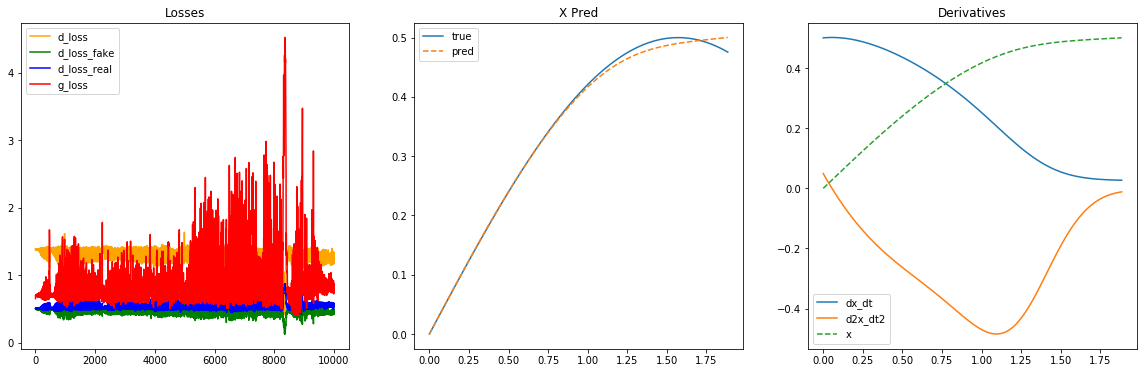

CPU times: user 6min 25s, sys: 51.7 s, total: 7min 17s
Wall time: 6min 36s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=9, # more D iters
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

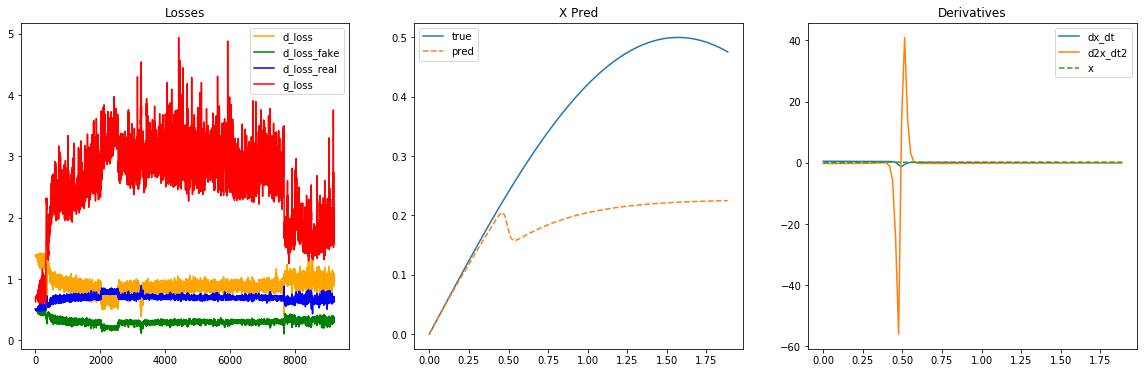

In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=3, # more D layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=9, # more D iters
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Conditional GAN

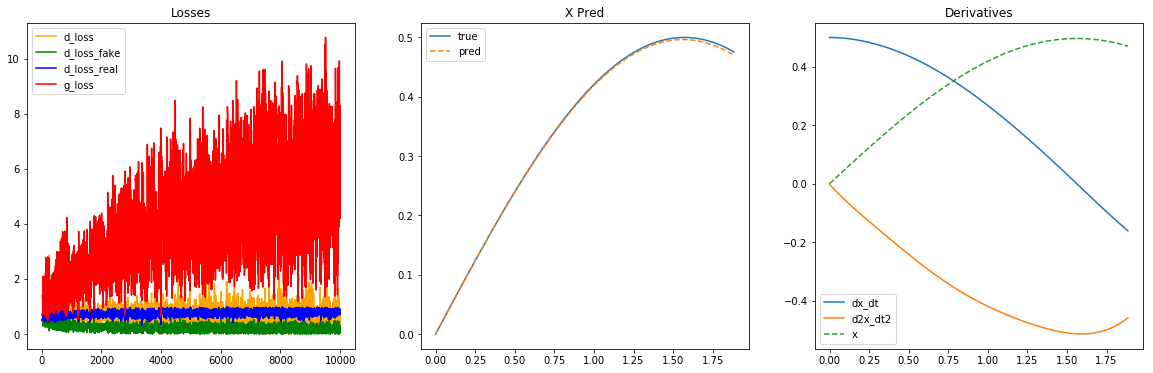

CPU times: user 4min 25s, sys: 44.8 s, total: 5min 10s
Wall time: 4min 28s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=.6*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Check preds outside?

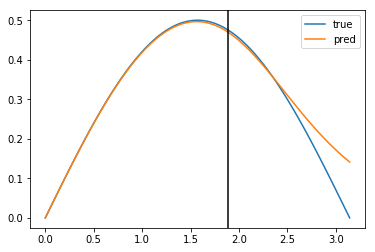

In [0]:
t_outside = torch.linspace(0, np.pi, 100, dtype=torch.float, requires_grad=True).reshape(-1,1)
# preds_outside = G(t_outside)
x0 = 0
dx_dt0 = .5
def produce_SHO_preds(G, t):
#         transpose for vector input
#         t = torch.t(t)

        x_raw = G(t)
        
        # adjust for initial conditions on x and dx_dt
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_raw

        dx_dt = diff(x_adj, t)
        d2x_dt2 = diff(dx_dt, t)

        return x_adj, dx_dt, d2x_dt2
x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t_outside)
analytic_oscillator_np = lambda t: x0*np.cos(t) + dx_dt0*np.sin(t)
analytic_soln = analytic_oscillator_np(t_outside.detach().numpy())
plt.plot(t_outside.detach().numpy(), analytic_soln, label='true')
plt.plot(t_outside.detach().numpy(), x_adj.detach().numpy(), label='pred')
plt.axvline(0.6*np.pi, color='k')
plt.legend();

## Fitting on $(0, \pi)$

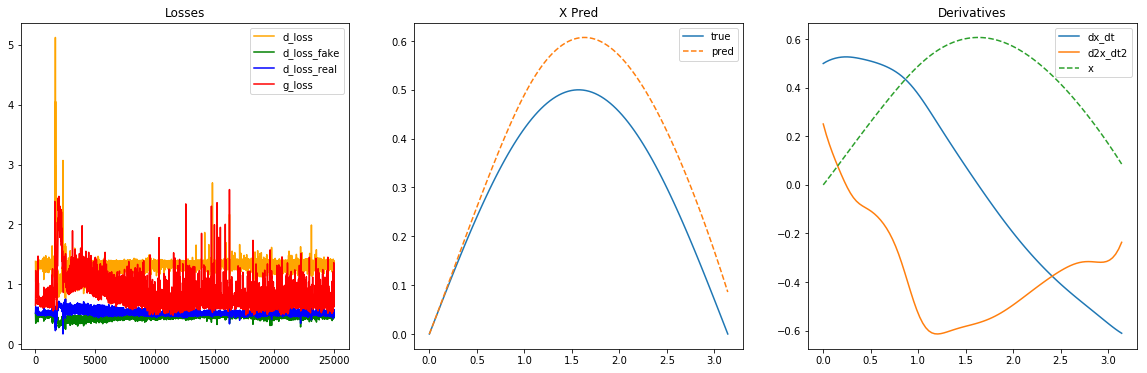

CPU times: user 10min 32s, sys: 1min 52s, total: 12min 24s
Wall time: 10min 44s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

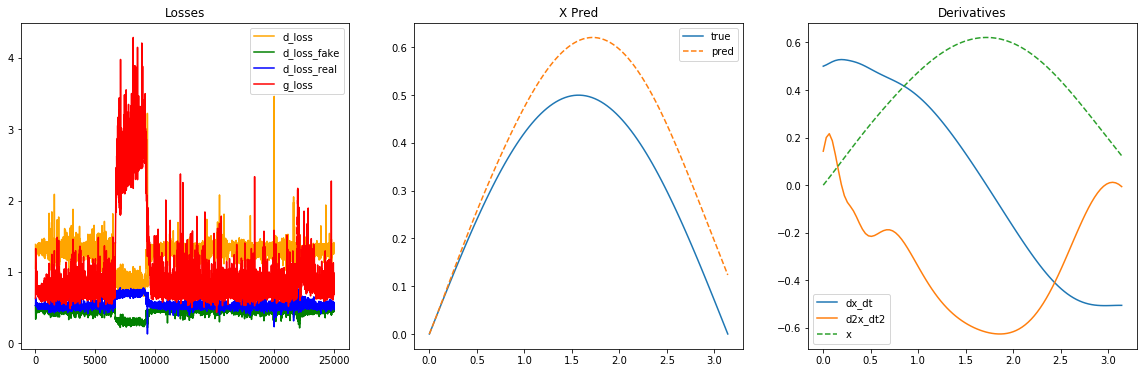

CPU times: user 11min 8s, sys: 1min 54s, total: 13min 2s
Wall time: 11min 16s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

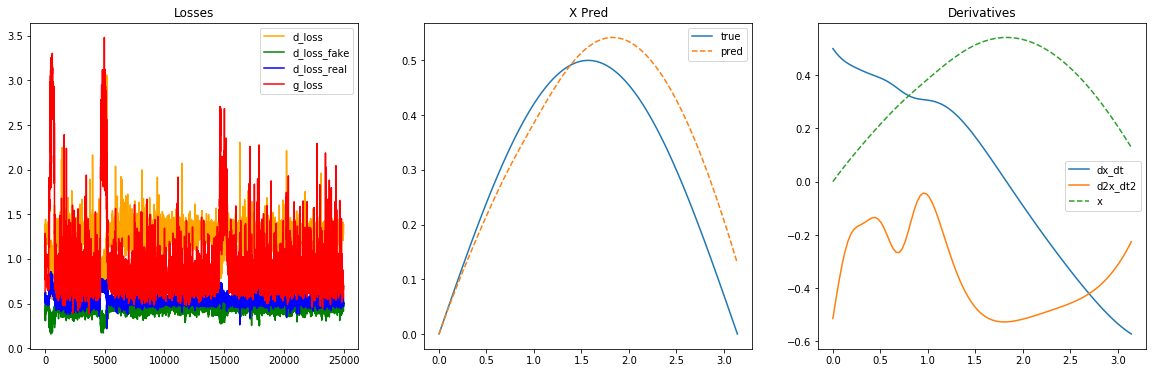

CPU times: user 11min 22s, sys: 1min 57s, total: 13min 19s
Wall time: 11min 29s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=20, 
                                  d_hidden_layers=3,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

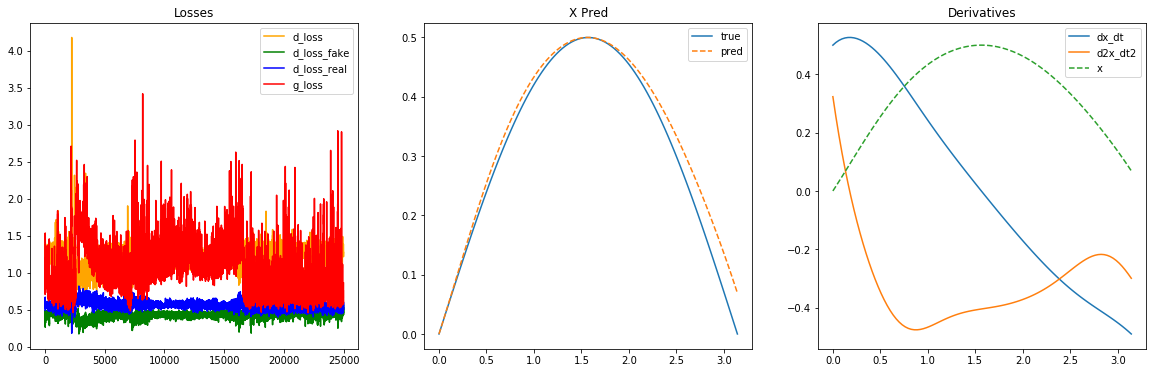

CPU times: user 11min 44s, sys: 2min, total: 13min 44s
Wall time: 11min 53s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

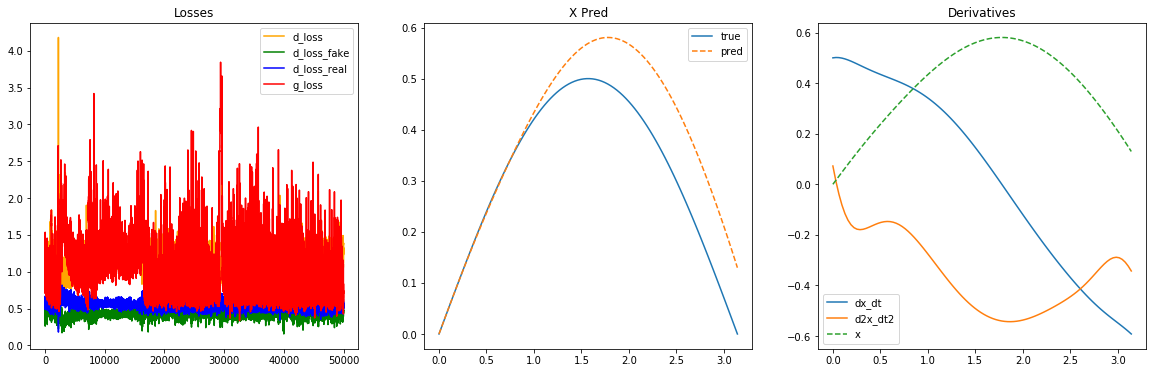

CPU times: user 24min 24s, sys: 4min 5s, total: 28min 29s
Wall time: 24min 37s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  50000,  # more epoch

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=30, 
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

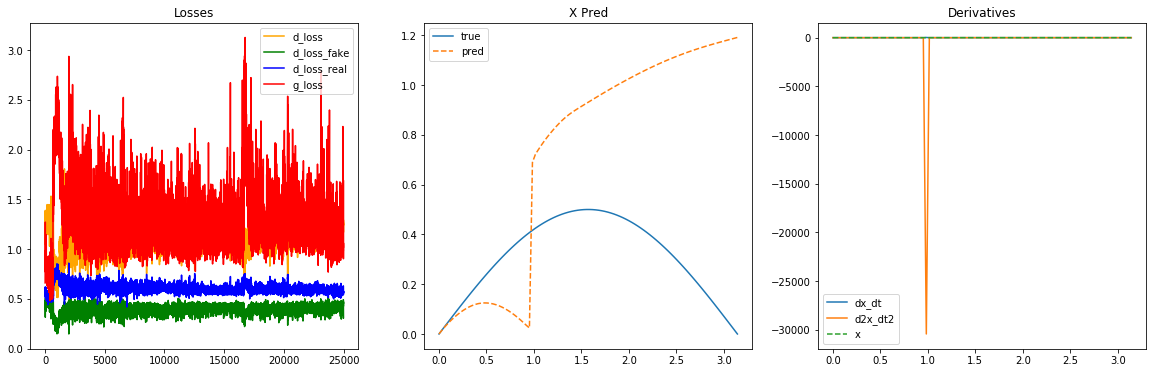

CPU times: user 12min 12s, sys: 2min 1s, total: 14min 14s
Wall time: 12min 21s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=40, # more node
                                  g_hidden_layers=3, 
                                  d_hidden_units=30, 
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

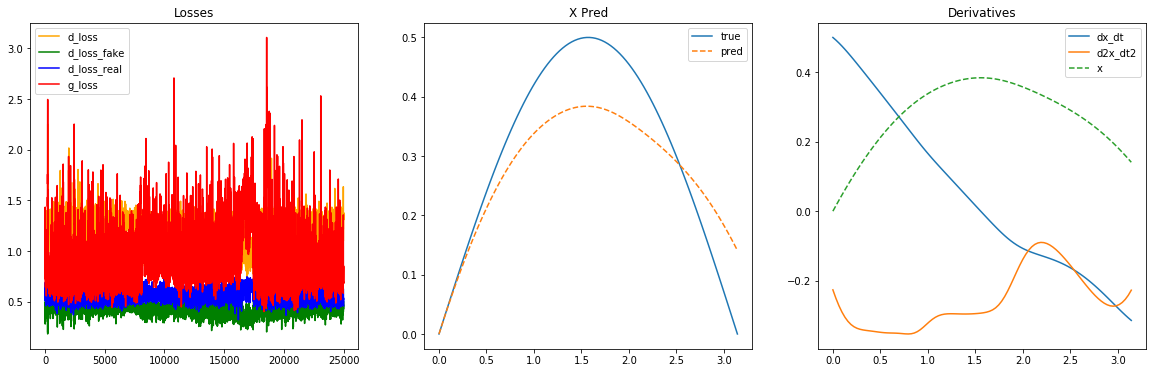

CPU times: user 12min 27s, sys: 2min 2s, total: 14min 30s
Wall time: 12min 36s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=40, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=40, # more node
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

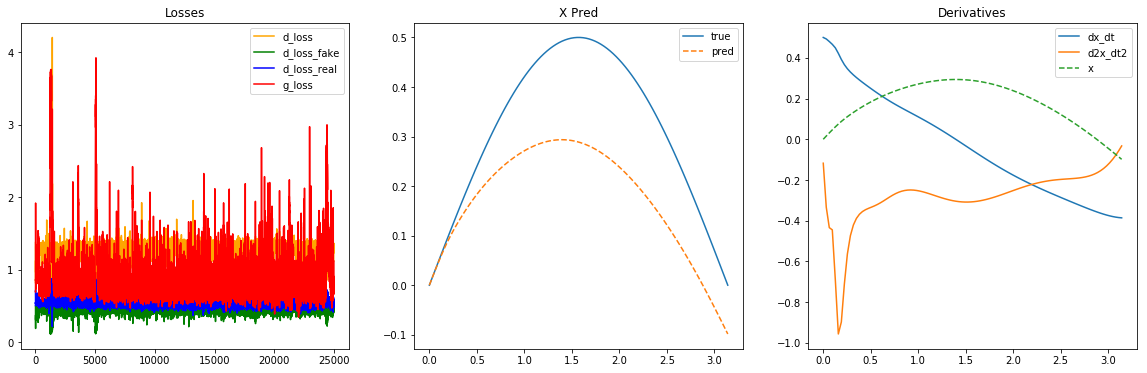

CPU times: user 12min 3s, sys: 1min 58s, total: 14min 2s
Wall time: 12min 12s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=40, # more node on D
                                  d_hidden_layers=3, 

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

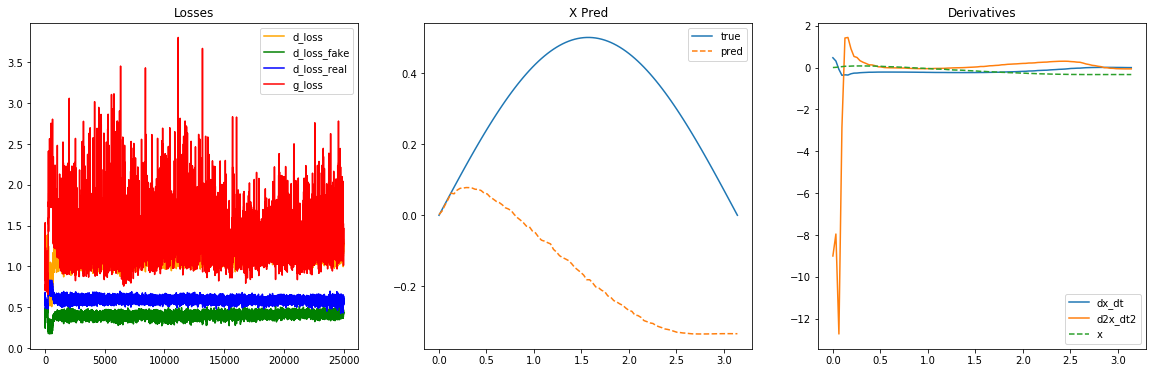

CPU times: user 12min 2s, sys: 2min 2s, total: 14min 4s
Wall time: 12min 11s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=True)

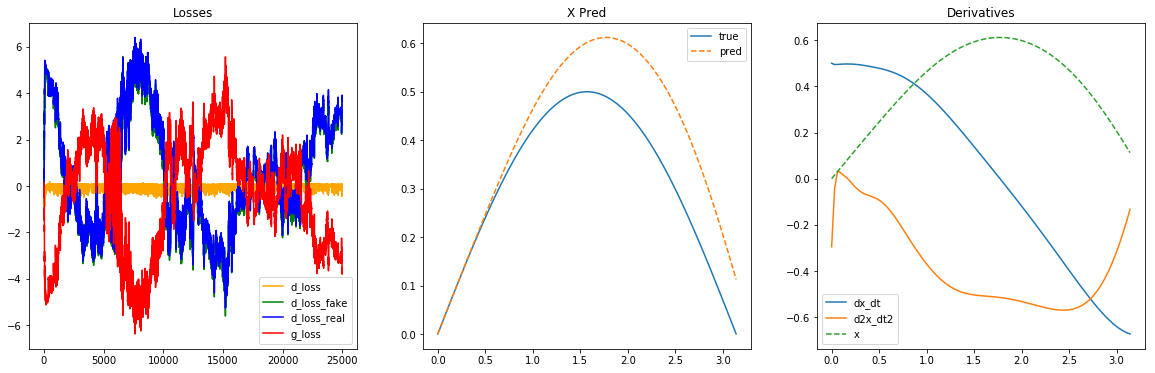

CPU times: user 32min 15s, sys: 2min 40s, total: 34min 56s
Wall time: 33min 10s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=True,
                                  gradient_penalty=True,
                                  gp_hyper=.1,

                                  # SYSTEM
                                  systemOfODE=False)

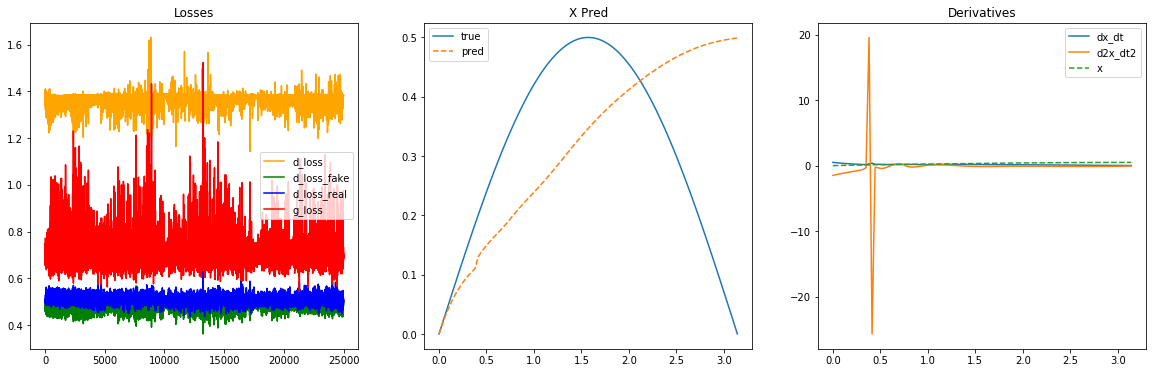

CPU times: user 9min 57s, sys: 1min 58s, total: 11min 56s
Wall time: 9min 59s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, # more layer
                                  d_hidden_units=30, # more node
                                  d_hidden_layers=3, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=True,  # use real                                    
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

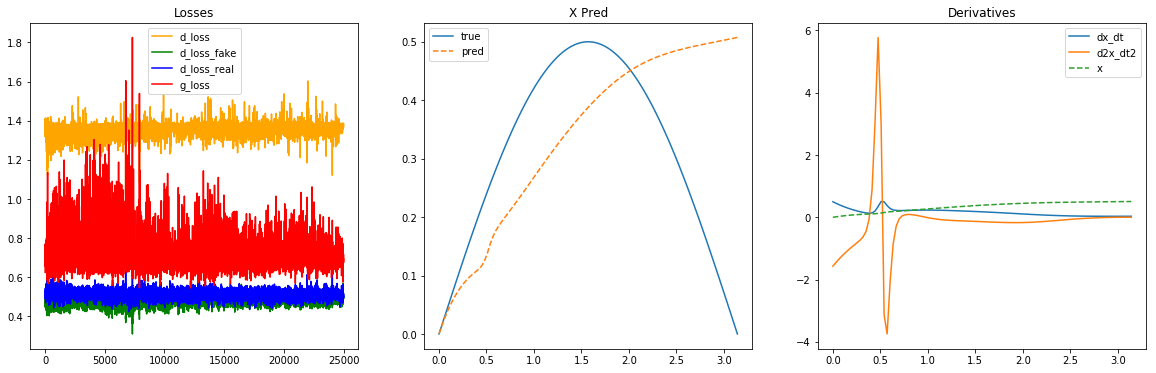

CPU times: user 10min 9s, sys: 1min 57s, total: 12min 7s
Wall time: 10min 14s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3, 
                                  d_hidden_units=30, 
                                  d_hidden_layers=4, # more layer

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=1.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=True,  # use real                                    
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Conditional GAN

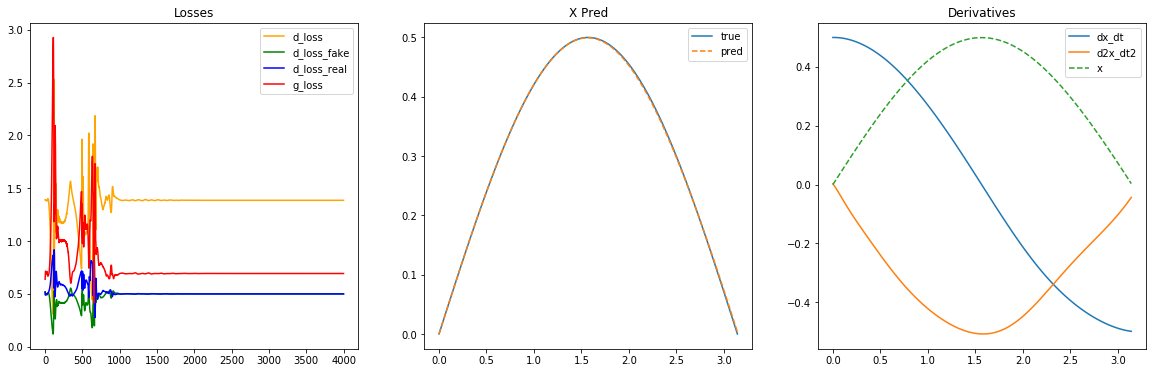

CPU times: user 59.1 s, sys: 13.7 s, total: 1min 12s
Wall time: 58.5 s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  4000, # less eps

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## Fitting on $(0,2\pi)$

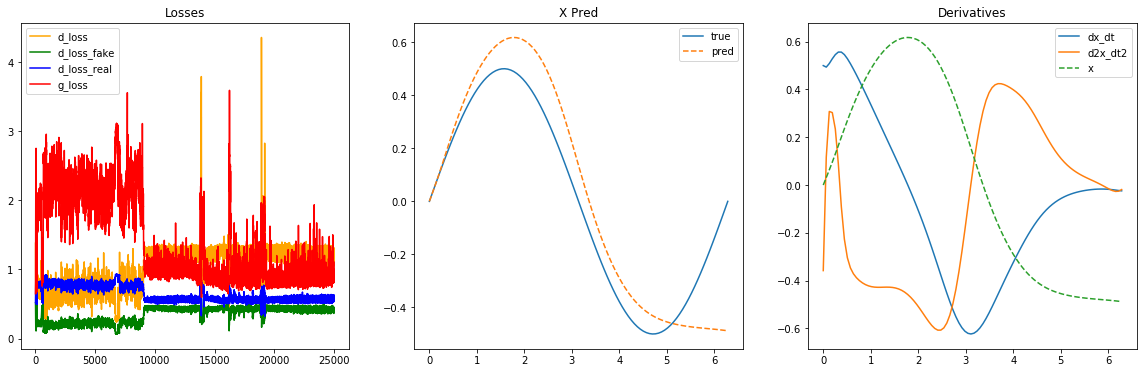

CPU times: user 10min 51s, sys: 2min, total: 12min 51s
Wall time: 10min 57s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  25000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

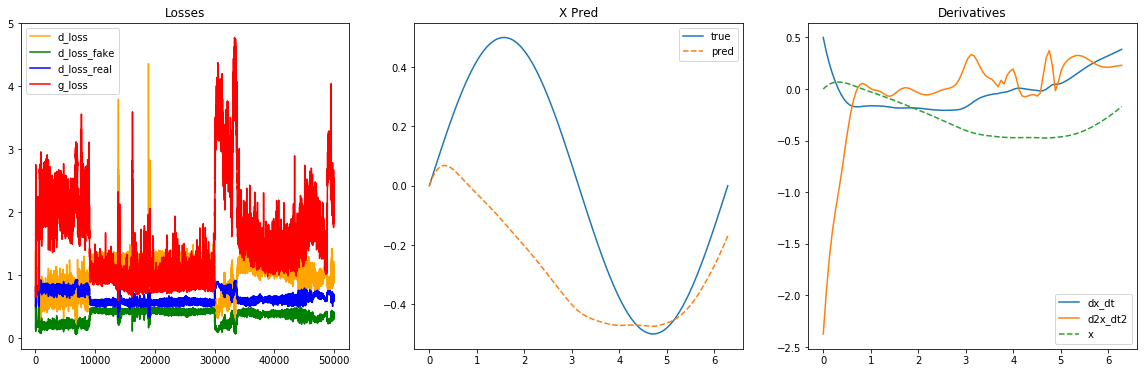

CPU times: user 21min 59s, sys: 4min 2s, total: 26min 2s
Wall time: 22min 10s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  50000,    # more epochs

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=20, 
                                  g_hidden_layers=3,
                                  d_hidden_units=20, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=1,
                                  D_iters=5,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0., 0.9),
                                  g_betas=(0., 0.9),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2.*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

## With Conditional GAN

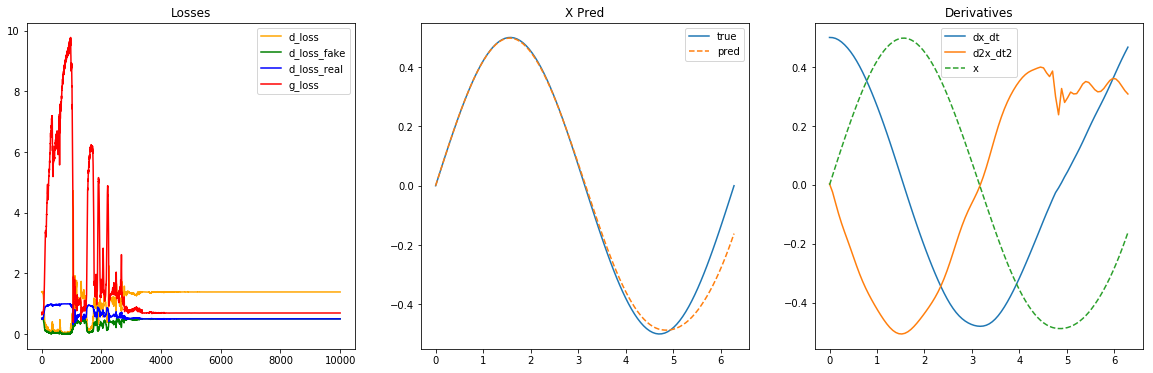

CPU times: user 4min 36s, sys: 42.1 s, total: 5min 19s
Wall time: 4min 44s


In [0]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
                                  # EPOCHS
                                  10000, 

                                  # NETWORKS
                                  activation=nn.Tanh(),
                                  g_hidden_units=30, 
                                  g_hidden_layers=3,
                                  d_hidden_units=30, 
                                  d_hidden_layers=2,

                                  # FROM WGAN-GP PAPER
                                  G_iters=4,
                                  D_iters=1,
                                  d_lr=0.001,
                                  g_lr=0.001,
                                  d_betas=(0.9, 0.999),
                                  g_betas=(0.9, 0.999),

                                  # PROBLEM      
                                  t_low=0,
                                  t_high=2*np.pi,
                                  n=100,
                                  x0=0.,
                                  dx_dt0=.5,

                                  # VIZ
                                  logging=False,
                                  realtime_plot=True,
                                  check_every=100,

                                  # Hacks
                                  real_data=False,                                      
                                  soft_labels=False,

                                  # WGAN
                                  wgan=False,
                                  gradient_penalty=True,
                                  gp_hyper=10.,

                                  # SYSTEM
                                  systemOfODE=False)

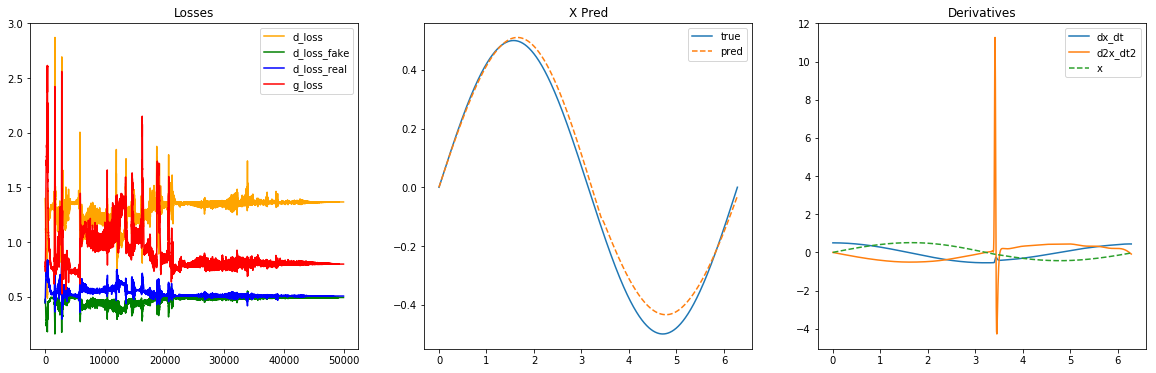

In [0]:
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=10,
  d_hidden_units=10,
  g_hidden_layers=2,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=4,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=2*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  loss_diff=.1,
  max_while=20,
  wgan=False,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=0.01,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=100,
  logging=False,
  realtime_plot=True,
  seed=42)

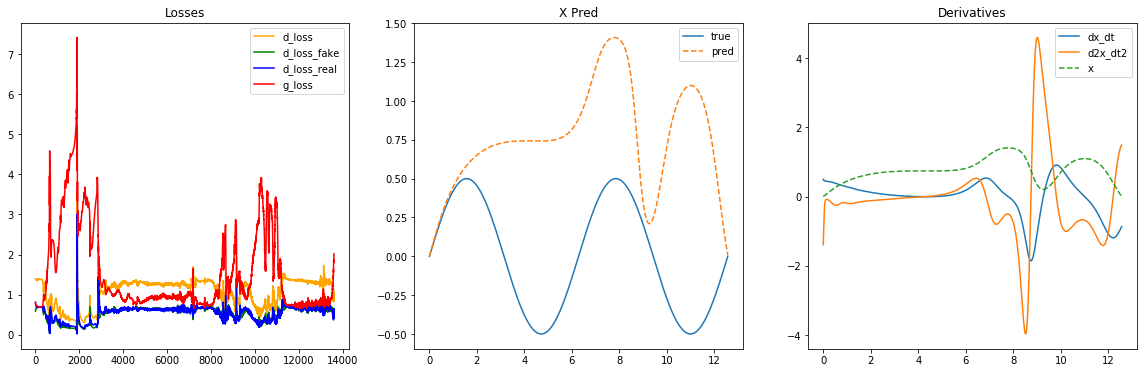

In [0]:
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=10,
  d_hidden_units=10,
  g_hidden_layers=2,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=4,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=False,
  clip=10.,
  gradient_penalty=True,
  gp_hyper=10.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=False,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=100,
  logging=False,
  realtime_plot=True,
  seed=42)

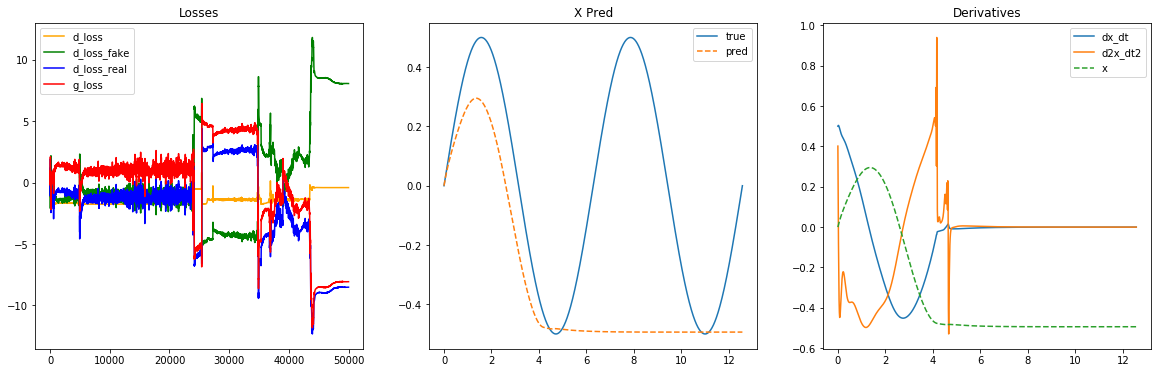

In [0]:
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=50000,
  activation=nn.Tanh(),
  g_hidden_units=50,
  d_hidden_units=50,
  g_hidden_layers=8,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

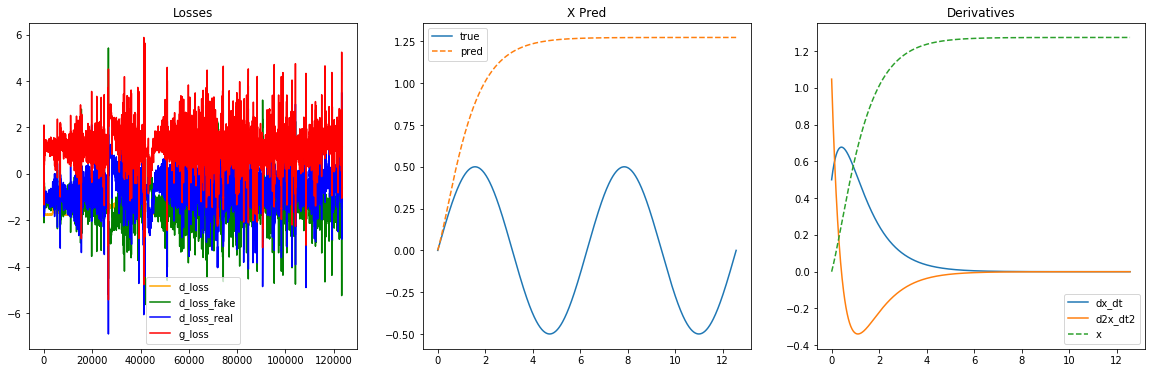

In [0]:
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=200000,
  activation=nn.Tanh(),
  g_hidden_units=50,
  d_hidden_units=50,
  g_hidden_layers=8,
  d_hidden_layers=5,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

In [0]:
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=200000,
  activation=nn.Tanh(),
  g_hidden_units=50,
  d_hidden_units=50,
  g_hidden_layers=2,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=4*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=5000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

# Trying every trick we know

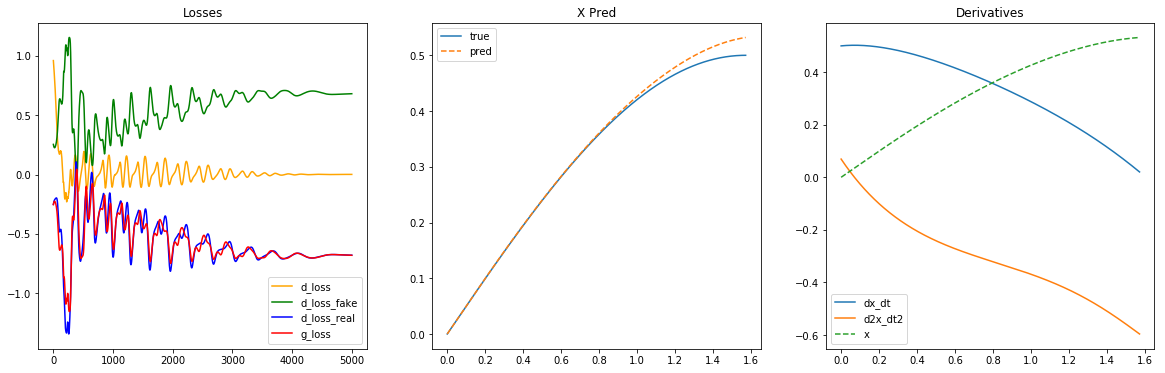

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=5000,
  activation=nn.Tanh(),
  g_hidden_units=10,
  d_hidden_units=10,
  g_hidden_layers=2,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=0.5*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=1000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

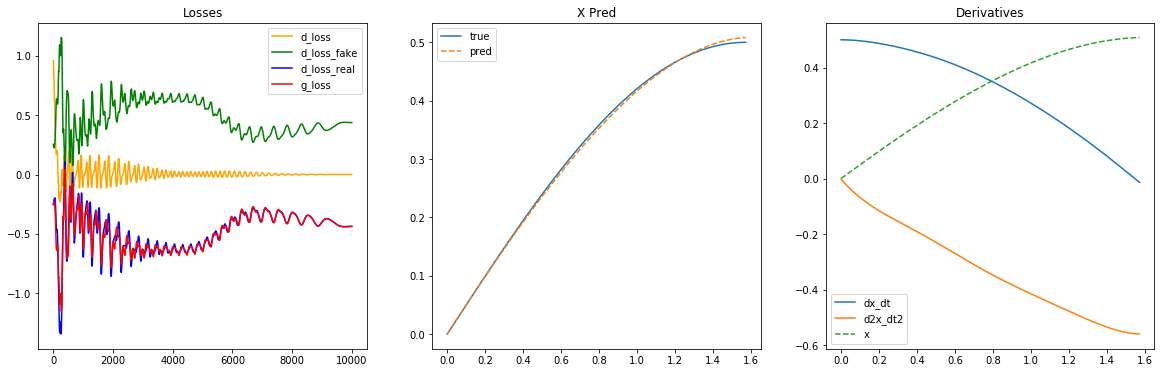

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=10000,
  activation=nn.Tanh(),
  g_hidden_units=10,
  d_hidden_units=10,
  g_hidden_layers=2,
  d_hidden_layers=2,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=0.5*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=1000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

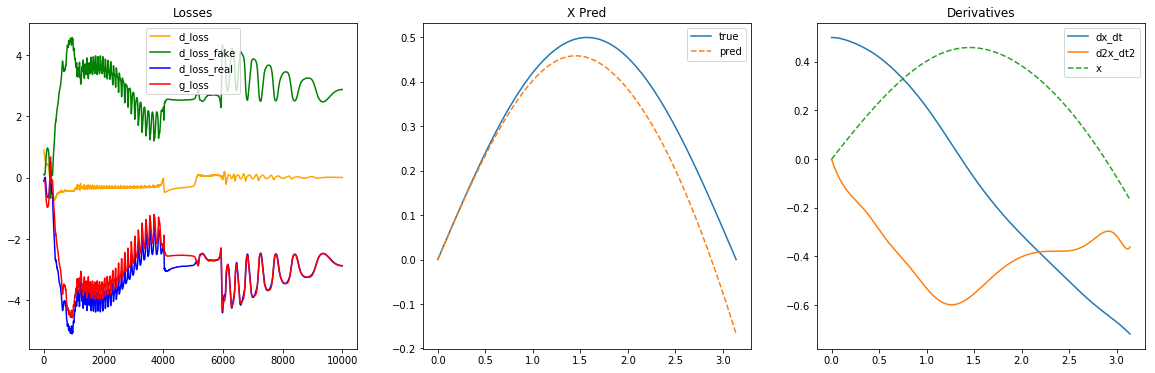

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=10000,
  activation=nn.Tanh(),
  g_hidden_units=10,
  d_hidden_units=10,
  g_hidden_layers=3,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=1.0*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=1000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)

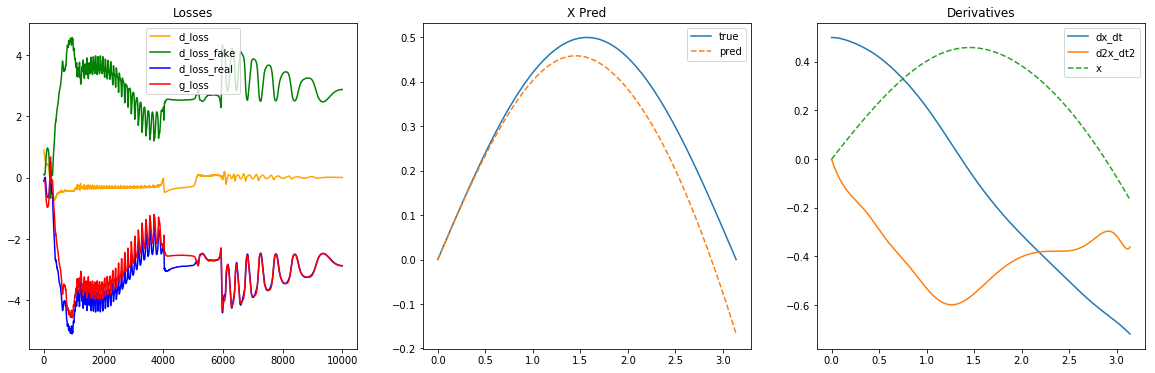

In [0]:
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
  # Architecture
  num_epochs=10000,
  activation=nn.Tanh(),
  g_hidden_units=10,
  d_hidden_units=10,
  g_hidden_layers=3,
  d_hidden_layers=3,
  d_lr=0.001,
  g_lr=0.001,
  d_betas=(0.9, 0.999),
  g_betas=(0.9, 0.999),
  G_iters=1,
  D_iters=1,
  # Problem
  t_low=0,
  t_high=1.0*np.pi,
  x0=0,
  dx_dt0=.5,
  n=1000,
  m=1.,
  k=1.,
  real_label=1,
  fake_label=0,
  # Hacks
  perturb=False,
  soft_labels=False,
  real_data=False,
  wgan=True,
  clip=.1,
  gradient_penalty=True,
  gp_hyper=1.,
  outputTan=True,
  systemOfODE=True,
  conditionalGAN=True,
  lr_schedule=True,
  decay_start_epoch=1000,
  # Inspect
  savefig=False,
  fname=None,
  device=None,
  check_every=500,
  logging=False,
  realtime_plot=True)